# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1:</center>
### <center>  Propiedades en Venta</center>
### <center>  Grupo 18</center>


#### **Integrantes:**

* Analía Acevedo
* Santiago Daniel Marczewski Neudeck
* Lucia Belén Napoli
* Brayan Ricaldi

#### **Introducción**

En este trabajo práctico se propone que cada grupo de alumnos se enfrente a un problema real
de ciencia de datos, que trabaje en cada una de las etapas del proceso y que pueda resolverlo
aplicando los contenidos que vemos en la materia.

Vamos a utilizar el conjunto de datos provisto por la empresa [Properati](https://www.properati.com.ar/) correspondiente a anuncios de propiedades en venta de la República Argentina publicados durante el año 2021 .
La información fue extraída desde BigQuery (producto de Google Cloud para consultar grandes
volúmenes de datos) donde la empresa disponibiliza sus datasets con avisos de propiedades y
desarrollos inmobiliarios que están y estuvieron publicados en Properati en todo Latinoamérica
desde 2015 hasta dos meses atrás. Los datos se actualizan diariamente para mayor información
pueden consultar el siguiente [link](https://www.properati.com.ar/data/).

El objetivo principal del trabajo será aplicar técnicas de análisis exploratorio, preprocesamiento
de datos, agrupamiento, clasificación y regresión. En la sección enunciado se detallan los
objetivos particulares.

#### **Descargamos en DataSet**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn.preprocessing as skp

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

pd.options.display.max_columns = None

In [2]:
# url='https://drive.google.com/file/d/1wScqb_M8lq3yL3ZfSZvnLyZbh4ImI7dI/view?usp=sharing'
# url='https://drive.google.com/uc?id=' + url.split('/')[-2]
# dp_properati = pd.read_csv(url)

dp_properati = pd.read_csv("./Datasets/properati_argentina_2021.csv")

In [3]:
df = dp_properati.copy()

Damos un primer vistazo al dataset

In [4]:
df.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


In [5]:
df.shape

(460154, 20)

Podemos ver que tenemos al rededor de 460 mil entradas y 20 columnas:
* id: Un codigo de identificacion.
* start_date: La fecha de inicio de la publicacion.
* end_date: La fecha de finalizacion de la publicacion.
* created_on: La fecha de creacion de la publicacion.
* latitud: La latitud en la que se encuentra la propiedad.
* longitud: La longitud en la que se encuentra la propiedad.
* place_2..n: Son 5 columnas con datos sobre la ubicacion de la propiedad, como provincia, ciudad, barrio, etc.
* operation: El tipo de operacion de la publicacion, como venta, alquiler, etc.
* property_type: El tipo de propiedad, como casa, departamento, PH, etc.
* property_room: La cantidad de ambientes que posee la propiedad.
* property_bedroom: La cantidad de dormitorios que posee la propiedad.
* property_surface_total: La superficie total de la propiedad.
* property_surface_covered: La superficie cubierta de la propiedad.
* property_price: El precio de la propiedad.
* property_currency: La moneda en la que esta expresada el precio publicado.
* property_title: El titulo de la publicacion.

#### **Enunciado**
El conjunto de datos a utilizar properati_argentina_2021 se encuentra disponible en el
siguiente [enlace](https://drive.google.com/drive/folders/1BPCdW_Jab91WhMqfXcf0jYMHzjxW_XkD?usp=sharing), la descripción de las variables se encuentra disponible [aquí](https://www.properati.com.ar/data/). Para este trabajo
se plantean los siguientes objetivos generales:

* _Agrupamiento_: el objetivo será analizar si es posible agrupar los datos en función de
algún criterio, identificando a qué obedece el mismo.

* _Clasificación_: el objetivo será clasificar cada anuncio en tres categorías relacionadas al
precio de venta (alto, medio y bajo).

* _Regresión_: el objetivo será predecir el precio de venta en dólares de una propiedad tipo
vivienda ubicada en Capital Federal.

A continuación se detallan las etapas que deben ser desarrolladas en el trabajo:

### **1. Análisis Exploratorio y Preprocesamiento de Datos**
El primer paso consiste en la selección de los datos que se van a utilizar, se deben filtrar
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).
Se debe separar un conjunto de entrenamiento (80%) y un conjunto de test (20%).

<h4 align="center"><b> Filtro por el enunciado </b></h4>

In [6]:
# Vamos a eliminar las filas que tengan precio en pesos o NaN
idx_prices = df[df.property_currency.apply(lambda curr: curr != "USD")].index
df.drop(idx_prices, inplace=True)
# Tambien eliminamos las propiedades que no se encuentren en Capital Federal
idx_location = df[df.place_l2.apply(lambda loc: loc != "Capital Federal")].index
df.drop(idx_location, inplace=True)
# Eliminamos las que no sean operaciones de tipo venta
idx_op = df[df.operation.apply(lambda op: op != "Venta")].index
df.drop(idx_op, inplace=True)
# Por ultimo eliminamos las que no sean de tipo vivienda
type_vivienda = ["Departamento", "PH", "Casa"]
idx_type = df[df.property_type.apply(lambda t: t not in type_vivienda)].index
df.drop(idx_type, inplace=True)
# Y reseteamos indices
df.reset_index(drop=True, inplace=True)

df.shape

(94249, 20)

Vemos si hay datos raros en el dataset properati

In [7]:
con_caracter_raro = df.astype("str").eq("-").any(0)
con_caracter_raro

id                          False
start_date                  False
end_date                    False
created_on                  False
latitud                     False
longitud                    False
place_l2                    False
place_l3                    False
place_l4                    False
place_l5                    False
place_l6                    False
operation                   False
property_type               False
property_rooms              False
property_bedrooms           False
property_surface_total      False
property_surface_covered    False
property_price              False
property_currency           False
property_title              False
dtype: bool

Vemos si hay filas duplicadas

In [8]:
# Armamos lista de las columnas excluyendo las que podrian dar problemas a la hora de identificar duplicados
columns = df.columns.tolist()[4:]
# Y buscamos duplicados
df[df.duplicated(subset=columns[:-1])].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
49,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,NaN,NaN,Venta,Departamento,NaN,4.0,400.0,NaN,2700000.0,USD,Departamento - Palermo Chico
186,5fV18BNo0KALCwNBrnNwlw==,2021-09-09,2022-01-27,2021-09-09,-34.604660,-58.395385,Capital Federal,Barrio Norte,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,42.0,38.0,85000.0,USD,Ayacucho 400 Monoambiente A ESTRENAR!
187,LIeYF5ewYWkjtBZb8xKt3g==,2021-09-09,2022-01-27,2021-09-09,-34.604660,-58.395385,Capital Federal,Barrio Norte,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,42.0,38.0,85000.0,USD,Ayacucho 400 Monoambiente A ESTRENAR!
188,ZB4UnAasDWbvahAXoG6m3A==,2021-09-09,2022-01-27,2021-09-09,-34.604660,-58.395385,Capital Federal,Barrio Norte,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,42.0,38.0,85000.0,USD,Ayacucho 400 Monoambiente A ESTRENAR!
243,53k8bQTyzBZ5vCcAjKIo6g==,2021-09-09,2022-02-09,2021-09-09,-34.580818,-58.491051,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,Departamento,2.0,1.0,100.0,87.0,189645.0,USD,POZO 3 AMBIENTES COCHERA OPCIONAL - VILLA URQUIZA


Las borramos y vemos cuantas son:

In [9]:
size_antes = len(df)
# Finalmente borramos los duplicados
df = df.drop_duplicates(subset=columns[:-1])
# Y reseteamos indices
df.reset_index(drop=True, inplace=True)
size_despues = len(df)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas")

Se eliminaron: 13236 filas duplicadas


Vemos la suma de datos nulos por columna

In [10]:
print(df.isna().sum())

id                              0
start_date                      0
end_date                        0
created_on                      0
latitud                      3136
longitud                     3136
place_l2                        0
place_l3                      395
place_l4                    78114
place_l5                    81013
place_l6                    81013
operation                       0
property_type                   0
property_rooms                958
property_bedrooms            9596
property_surface_total       4206
property_surface_covered     2828
property_price                  0
property_currency               0
property_title                  0
dtype: int64


Y tambien que porcentaje representan del total

In [11]:
filas_totales = df.shape[0]
print(df.isna().sum() / filas_totales * 100)

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.870984
longitud                      3.870984
place_l2                      0.000000
place_l3                      0.487576
place_l4                     96.421562
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.182526
property_bedrooms            11.845013
property_surface_total        5.191759
property_surface_covered      3.490798
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64


Se observa que hay un gran porcentaje de datos nulos en el feature place_l4. Ademas podemos ver que las features place_l5 y place_l6 tienen el 100% de sus filas nulas.

Solo nos quedamos con las longitudes y latitudes que pertenezcan a Capital Federal

In [12]:
# Guardamos el tamano del dataset
size_antes = len(df)
# Primero nos quedamos solamente con las filas con longitudes validas
df = df[(-58.5314375 < df["longitud"]) & (df["longitud"] < -58.3415625)]
# Y luego repetimos el proceso para las latitudes
df = df[(-34.7045625 < df["latitud"]) & (df["latitud"] < -34.5270625)]
# Buscamos el tamano del dataset despues de sacar coordenadas invalidas
size_despues = len(df)
# Y reseteamos indices
df.reset_index(drop=True, inplace=True)
print(f"Se eliminaron: {size_antes-size_despues} filas con coordenadas invalidas, lo cual representa un {round((size_antes-size_despues) / size_antes * 100, 3)}%")

Se eliminaron: 3326 filas con coordenadas invalidas, lo cual representa un 4.106%


In [13]:
tam_inicial=df.shape[0]
print(f"El tamano inicial del dataset luego de tomar solamente los datos requeridos es de: {tam_inicial} filas")

El tamano inicial del dataset luego de tomar solamente los datos requeridos es de: 77687 filas


#### Fechas

In [14]:
"""
Precondicion: 
        - f debe ser un feature de df.
        - Los datos de f son del formato yy-mm-dd
        - yy/mm/dd son int en formato string
"""


def procesar_fechas(df, f):
    day = []
    month = []
    year = []
    for date in df[f]:
        _year, _month, _day = date.split("-")
        day.append(int(_day))
        month.append(int(_month))
        year.append(int(_year))
    return day, month, year

In [15]:
# Descartamos el anio porque al ser un dataset unicamente del anio 2021 es un valor redundante
created_on_day, created_on_month, created_on_year = procesar_fechas(df, "created_on")
df["dia"] = created_on_day
df["mes"] = created_on_month

**a) Exploración Inicial:** analizar cada variable, considerando los siguientes aspectos
* Tipo de variable
* Variables Cuantitativas: calcular medidas de resumen: media, mediana, q1,
q3, moda.
* Variables Cualitativas mostrar cantidad de valores posibles, y frecuencias de cada
uno.
* Determinar variables irrelevantes en el análisis (Ids por ejemplo)
* Realizar un análisis gráfico de las distribuciones de las variables
* Analizar las correlaciones existentes entre las variables.

A partir de este análisis generar conclusiones sobre los datos.



<h4 align="center"><b> Tipo de variable </b></h4>

In [16]:
df.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77687 entries, 0 to 77686
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        77687 non-null  object 
 1   start_date                77687 non-null  object 
 2   end_date                  77687 non-null  object 
 3   created_on                77687 non-null  object 
 4   latitud                   77687 non-null  float64
 5   longitud                  77687 non-null  float64
 6   place_l2                  77687 non-null  object 
 7   place_l3                  77645 non-null  object 
 8   place_l4                  2528 non-null   object 
 9   place_l5                  0 non-null      object 
 10  place_l6                  0 non-null      float64
 11  operation                 77687 non-null  object 
 12  property_type             77687 non-null  object 
 13  property_rooms            76888 non-null  float64
 14  proper

Se observa que hay 12 variables string y 8 float

<h4 align="center"><b> Variables Cuantitativas - calcular medidas de resumen: media, mediana, q1
q3, moda. </b></h4>

<h4 align="center"><b> Realizar un análisis gráfico de las distribuciones de las variables </b></h4>

Veamos un resumen general estadistico de las variables cuantitativas:

In [17]:
medidas_resumen=df.describe()
medidas_resumen

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,dia,mes
count,77687.000000,77687.000000,0.0,76888.000000,68537.000000,73757.000000,75002.000000,7.768700e+04,77687.000000,77687.000000
mean,-34.596741,-58.439070,NaN,2.812923,2.008142,106.250159,87.975241,2.120536e+05,15.468508,6.479720
std,0.026524,0.038171,NaN,1.410074,1.131225,1009.162027,1090.052956,2.814634e+05,8.424364,3.413636
min,-34.698989,-58.530391,NaN,1.000000,-1.000000,10.000000,1.000000,5.000000e+03,1.000000,1.000000
25%,-34.616636,-58.466707,NaN,2.000000,1.000000,45.000000,40.000000,9.500000e+04,8.000000,3.000000
50%,-34.596323,-58.439267,NaN,3.000000,2.000000,65.000000,57.000000,1.400000e+05,16.000000,6.000000
75%,-34.577847,-58.409025,NaN,4.000000,3.000000,102.000000,87.000000,2.300000e+05,23.000000,9.000000
max,-34.535964,-58.343239,NaN,40.000000,70.000000,137000.000000,217000.000000,2.140000e+07,31.000000,12.000000


In [18]:
# df[f_float].mode()

#### Observemos cada feature en mas detalle:

In [19]:
"""
Precondicion: 
        - f debe ser un feature numerico de df y contener al menos una fila valida.
"""

def imprimir_resumen(df, f):
    media = round(df[f].mean(),1)
    mediana = df[f].median()
    cuantiles = df[f].quantile(q=[0.25,0.75])
    moda = df[f].mode()
    q1=round(cuantiles.iloc[0],1)
    q3=round(cuantiles.iloc[1],1)
    return pd.DataFrame({'media': media,'mediana': mediana,'q1': q1,'q3': q3,'moda': moda[0]}, index=[f])

#### Fecha de publicacion (dia y mes):

Text(0.5, 1.0, 'Distribucion de mes de publicacion')

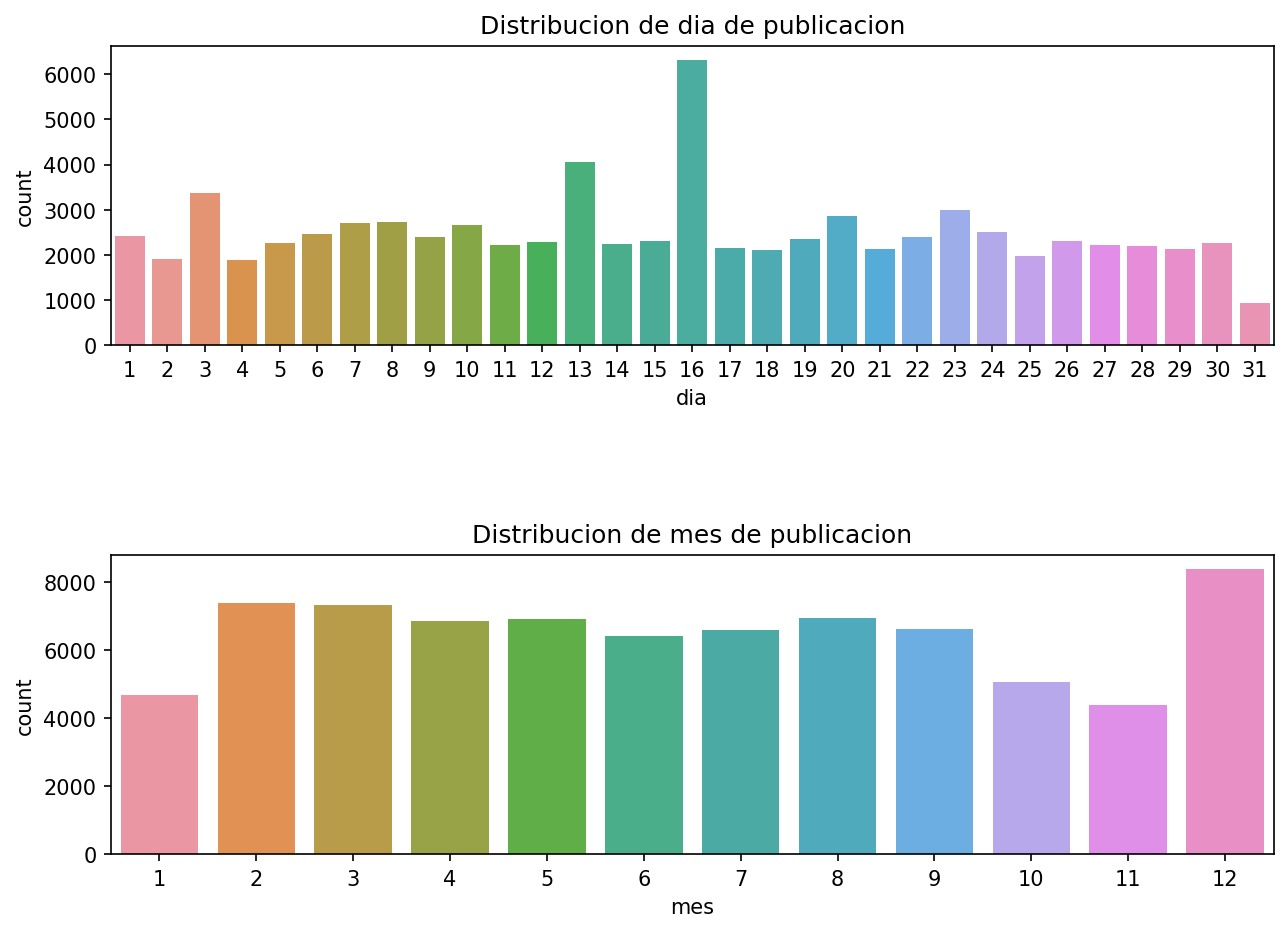

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=150, figsize=(10, 7))
sns.countplot(
    x="dia",
    data=df,
    ax=axes[0],
)
sns.countplot(
    x="mes",
    data=df,
    ax=axes[1],
)
plt.subplots_adjust(hspace=0.7)
axes[0].set_title("Distribucion de dia de publicacion")
axes[1].set_title("Distribucion de mes de publicacion")

Podemos observar que el mes mas popular para publicar una propiedad a la venta es Diciembre, mientras que el dia mas elegido es el 16.

#### Longitud y Latitud:

In [21]:
# Medidas de resumen para la variable longitud
imprimir_resumen(df, 'longitud')

,media,mediana,q1,q3,moda
longitud,-58.4,-58.439267,-58.5,-58.4,-58.424956


In [22]:
# Medidas de resumen para la variable latitud
imprimir_resumen(df, 'latitud')

,media,mediana,q1,q3,moda
latitud,-34.6,-34.596323,-34.6,-34.6,-34.604538


Text(0.5, 1.0, 'Latitud')

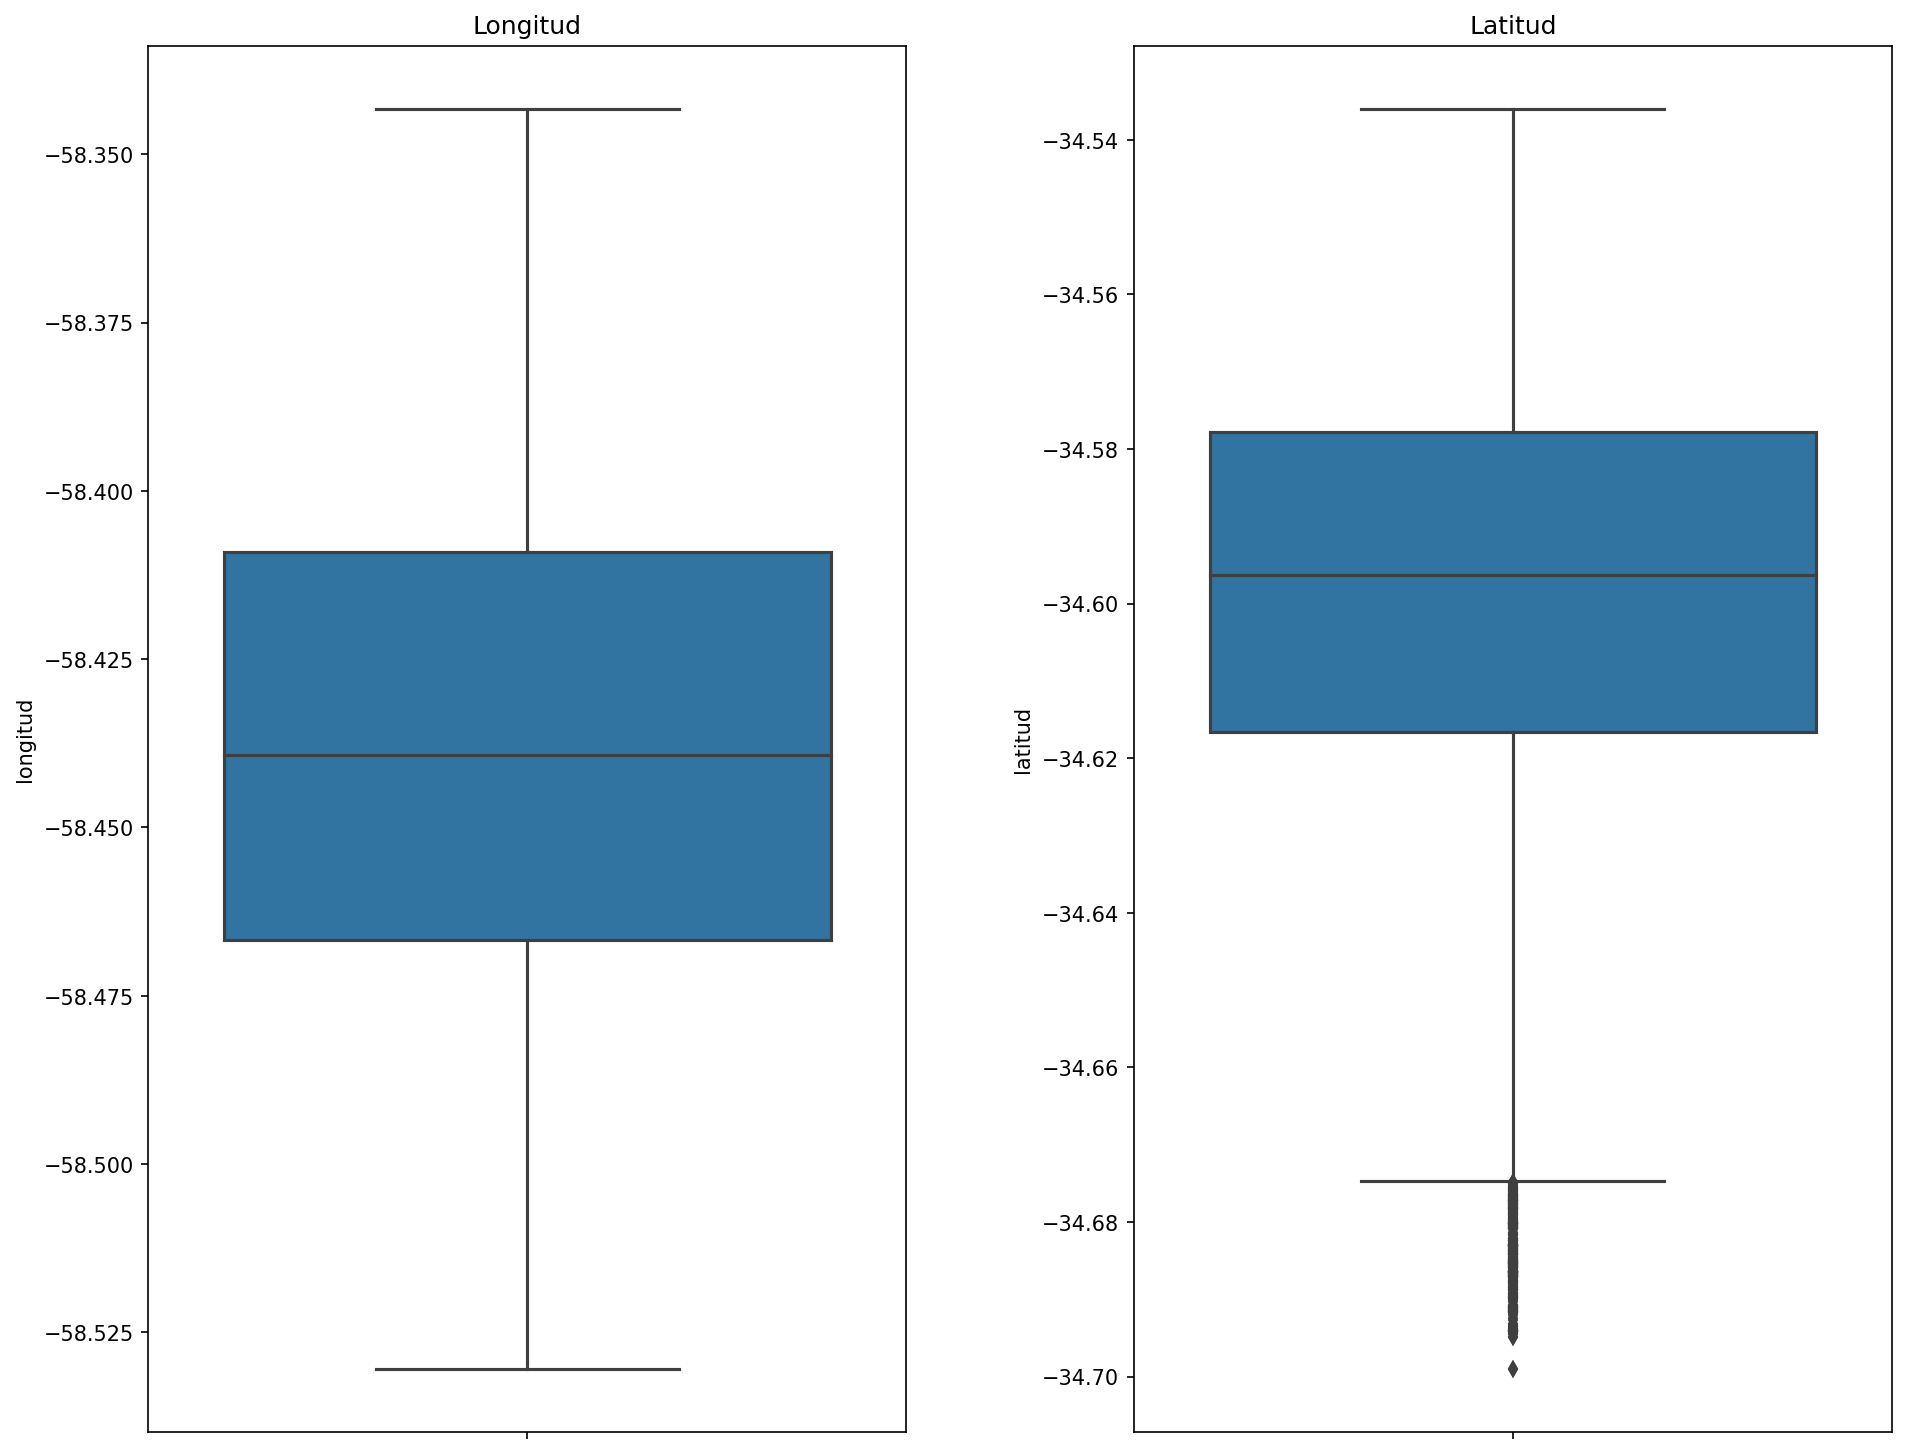

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(15, 12))
sns.boxplot(y=df["longitud"], ax=axes[0])
sns.boxplot(y=df["latitud"], ax=axes[1])
plt.subplots_adjust(wspace=0.3)
axes[0].set_title("Longitud")
axes[1].set_title("Latitud")

#### Precio (property_price):

In [24]:
# Medidas de resumen para la variable property_price
imprimir_resumen(df, 'property_price')

,media,mediana,q1,q3,moda
property_price,212053.6,140000.0,95000.0,230000.0,110000.0


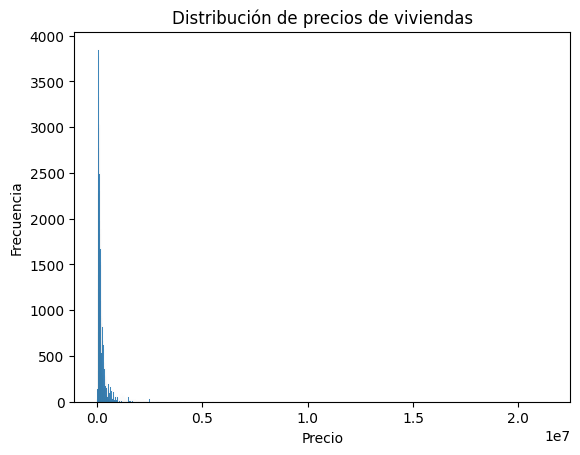

In [25]:
# Histograma de los precios
# sns.set(rc={"figure.figsize":(10, 45)})
sns_hist = sns.histplot(data=df["property_price"], alpha=0.85).set(
    title="Distribución de precios de viviendas", xlabel="Precio", ylabel="Frecuencia"
)

#### Ambientes (property_rooms):

In [26]:
# Medidas de resumen para la variable property_rooms
imprimir_resumen(df, 'property_rooms')

,media,mediana,q1,q3,moda
property_rooms,2.8,3.0,2.0,4.0,3.0


In [27]:
# Vemos cuantos valores unicos hay en la columna, el dato es interesante ya que el rango de valores deberia ser bastante acotado
print(f"El feature Ambientes tiene: {len(df.property_rooms.unique())} valores unicos")

El feature Ambientes tiene: 27 valores unicos


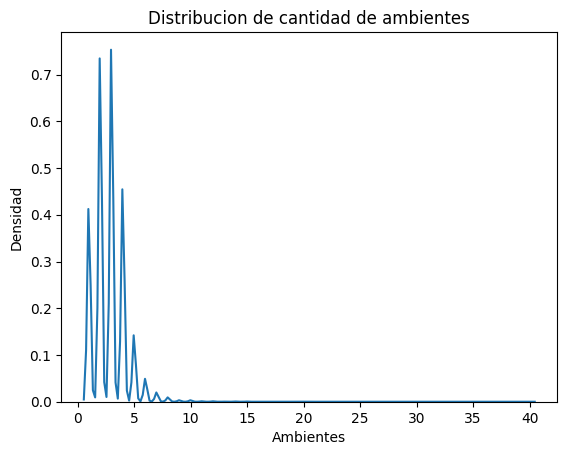

In [28]:
# Distribucion de la variable property_rooms
sns_hist = sns.kdeplot(data=df.property_rooms).set(
    title="Distribucion de cantidad de ambientes", xlabel="Ambientes", ylabel="Densidad"
)

#### Dormitorios (property_bedrooms)

In [29]:
# Medidas de resumen para la variable property_bedrooms
imprimir_resumen(df, 'property_bedrooms')

,media,mediana,q1,q3,moda
property_bedrooms,2.0,2.0,1.0,3.0,1.0


In [30]:
# Vemos cuantos valores unicos hay en la columna, el dato es interesante ya que el rango de valores deberia ser bastante acotado
print(f"El feature Dormitorios tiene: {len(df.property_bedrooms.unique())} valores unicos")

El feature Dormitorios tiene: 25 valores unicos


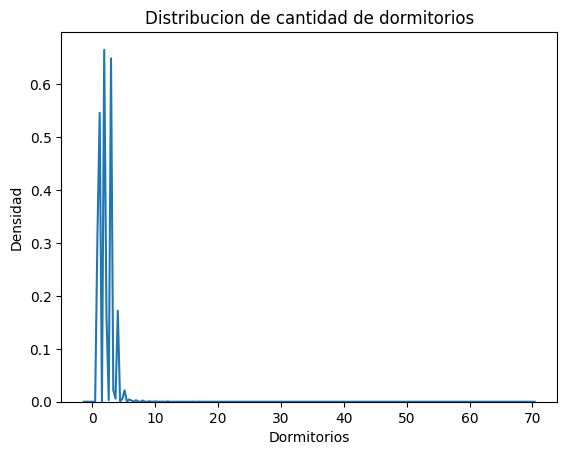

In [31]:
# Distribucion de la variable property_bedrooms
sns_hist = sns.kdeplot(data=df.property_bedrooms).set(
    title="Distribucion de cantidad de dormitorios",
    xlabel="Dormitorios",
    ylabel="Densidad",
)

#### Superficie total (property_surface_total)

In [32]:
# Medidas de resumen para la variable property_surface_total
imprimir_resumen(df, 'property_surface_total')

,media,mediana,q1,q3,moda
property_surface_total,106.3,65.0,45.0,102.0,40.0


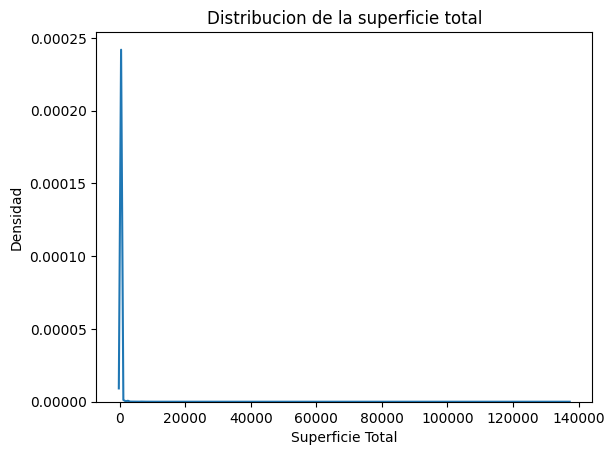

In [33]:
# Distribucion de la variable property_surface_total
sns_hist = sns.kdeplot(data=df.property_surface_total).set(
    title="Distribucion de la superficie total",
    xlabel="Superficie Total",
    ylabel="Densidad",
)

#### Superficie cubierta (property_surface_covered)

In [34]:
# Medidas de resumen para la variable property_surface_covered
imprimir_resumen(df, 'property_surface_covered')

,media,mediana,q1,q3,moda
property_surface_covered,88.0,57.0,40.0,87.0,40.0


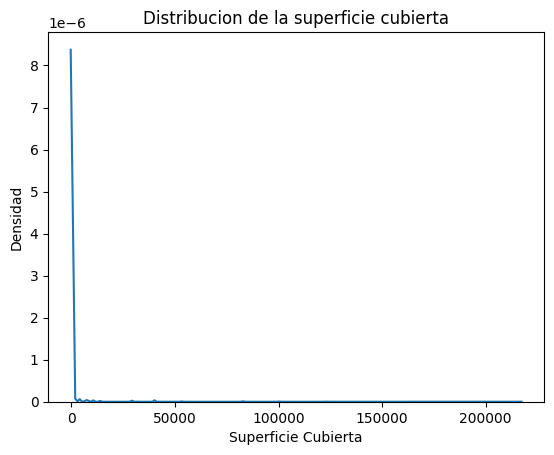

In [35]:
# Distribucion de la variable property_surface_covered
sns_hist = sns.kdeplot(data=df.property_surface_covered).set(
    title="Distribucion de la superficie cubierta",
    xlabel="Superficie Cubierta",
    ylabel="Densidad",
)

<h4 align="center"><b> Variables Cualitativas - mostrar cantidad de valores posibles, y frecuencias de cada
uno </b></h4>

#### Tipo (property_type)

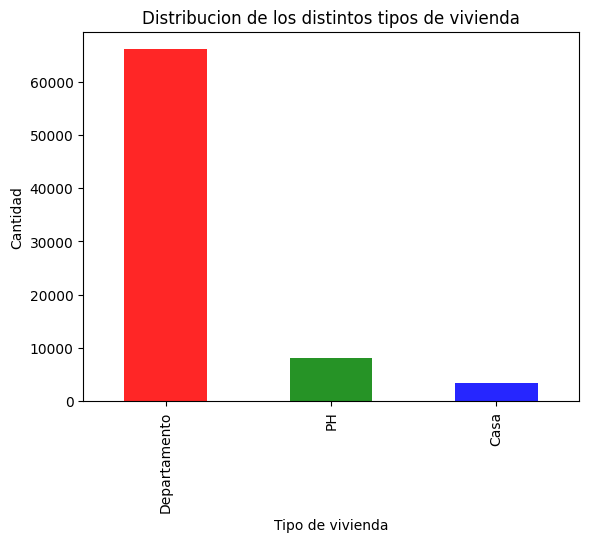

In [36]:
# Gráfico de barras
grf_ds = (
    df["property_type"]
    .value_counts()
    .plot.bar(
        alpha=0.85,
        title="Distribucion de los distintos tipos de vivienda",
        xlabel="Tipo de vivienda",
        ylabel="Cantidad",
        color=['r','g','b']
    )
)

Podemos ver que el tipo mas frecuente de propiedad es Departamento.

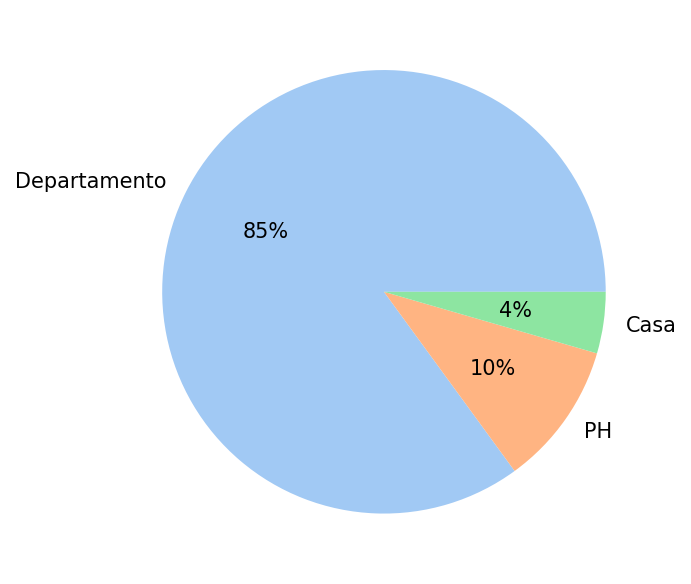

In [37]:
# Grafico de torta
plt.figure(dpi=150)
data = df["property_type"].value_counts()
labels = df["property_type"].value_counts().index
colors = sns.color_palette("pastel")

plt.pie(data, labels=labels, colors=colors, autopct="%.0f%%")
plt.show()

Especificamente el 86% de los datos corresponde a una publicacion de departamento.

#### Barrios (place_l3)

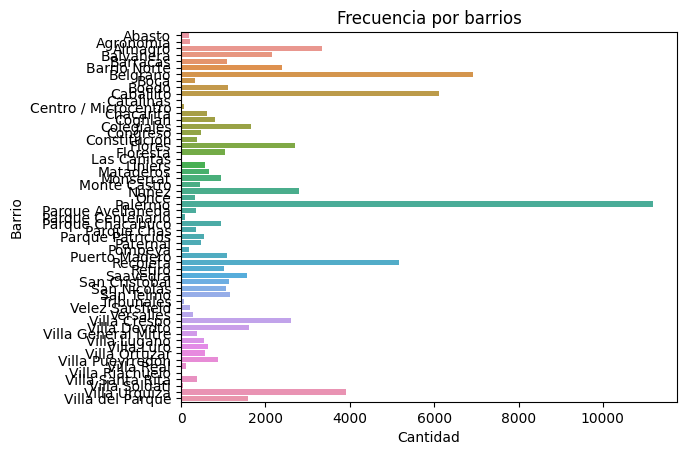

In [38]:
# Seaborn
ds_agrupado_Pclass = df.groupby(
    ["place_l3"]
).count()  # Calculo la frecuencia de cada barrio

eje_y = ds_agrupado_Pclass.index.tolist()
eje_x = ds_agrupado_Pclass["property_price"].tolist()
# sns.set(rc={"figure.figsize":(15, 45)})
sns_bar_plot = sns.barplot(
    x=eje_x, y=eje_y, data=ds_agrupado_Pclass, orient="h"
).set(title="Frecuencia por barrios", xlabel="Cantidad", ylabel="Barrio")

#### Título del anuncio (property_title)

Si bien la informacion que podamos obtener del titulo de la publicacion es limitada al ser un campo que puede cambiar mucho y depende exclusivamente de la persona que la escribe, vamos a analizarla de todas maneras para intentar encontrar algo que pueda servirnos.

In [39]:
df["property_title"].value_counts().head(60)

Departamento - Recoleta                            1094
Departamento - Palermo                             1066
Departamento - Belgrano                             896
Departamento - Caballito                            789
Departamento - Villa Urquiza                        526
Departamento - Barrio Norte                         519
Departamento - Almagro                              517
Departamento - Flores                               388
Departamento - Villa Crespo                         387
Departamento - Nuñez                                340
Departamento venta                                  331
Departamento - Balvanera                            305
Departamento - Puerto Madero                        286
Departamento - Las Cañitas                          251
Departamento - San Telmo                            250
Departamento - Colegiales                           242
Departamento - Palermo Hollywood                    229
Departamento - Saavedra                         

Entre los formatos mas populares se encuentra: TIPO - BARRIO.

In [40]:
df["property_title"].value_counts().tail(10)

VENTA -2 AMBIENTES CON COCHERA Y BAULERA EN TORRE DUOMO - VILLA CRESPO                                  1
Venta Departamento 2 ambientes ideal inversion Almagro                                                  1
VENTA DUPLEX 2 AMBIENTES, B° NÚÑEZ                                                                      1
Venta 4 amb con cochera Monte Castro                                                                    1
Venta en Belgrano - 2Amb con toilette - 61MtsTotales - TERRAZA - PISCINA - SUM                          1
VENTA DEPARTAMENTO U OFICINA, APTO PROFESIONAL IDEAL INVERSOR                                           1
2 AMBIENTES CABA con Cochera                                                                            1
VENTA Hermoso 2 ambientes amplio!!!                                                                     1
Departamento 2 ambientes muy luminoso en TORRE MY SOHO - Villa Crespo                                   1
VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF 

Y naturalmente entre los formatos menos frecuentes encontramos convenciones muy variadas.

In [41]:
df_title = df.groupby("property_title").filter(lambda x: len(x) > 200)

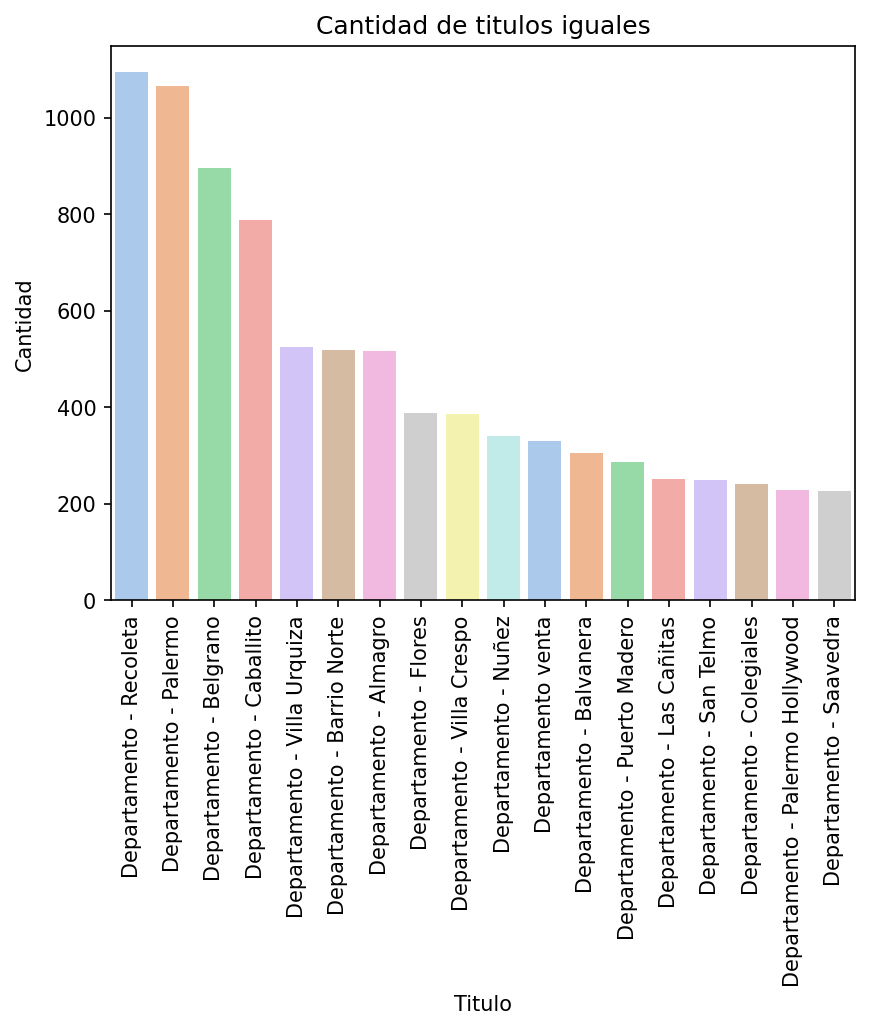

In [42]:
plt.figure(dpi=150)
colors = sns.color_palette("pastel")
sns.countplot(
    x="property_title",
    data=df_title,
    palette=colors,
    order=df_title.property_title.value_counts().index,
)
plt.ylabel("Cantidad")
plt.xlabel("Titulo")
plt.xticks(rotation=90)
plt.title("Cantidad de titulos iguales")
plt.show()

In [43]:
df_t = df["property_title"].str.split("-", expand=True)
df_t.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Departamento,4 Ambientes,Catalinas Sur,None,None,None,None,None,None,None,None,None,None,None,None,None
2,Venta departamento 4 ambientes Once,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,PH,Boedo,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,PH 2 Ambientes c/Patio HECHO A NUEVO,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [44]:
df_t = df_t[[0, 1]]
df_t.columns = ["Tipo", "Barrio"]
df_t

,Tipo,Barrio
0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,None
1,Departamento,4 Ambientes
2,Venta departamento 4 ambientes Once,None
3,PH,Boedo
4,PH 2 Ambientes c/Patio HECHO A NUEVO,None
...,...,...
77682,Espectacular 4 amb130m2 con Balcon Terraza!!!,None
77683,3 ambientes con cochera listo para habitar!,None
77684,VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA ///...,None
77685,VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF ...,None


In [45]:
df_t = df_t.loc[
    (df_t["Tipo"] == "Casa") | (df_t["Tipo"] == "PH") | (df_t["Tipo"] == "Departamento")
]
df_t.head(10)

,Tipo,Barrio
1565,PH,Triplex tipo casa con cochera y jardin!
3566,Casa,Saavedra
3583,Casa,venta
4915,PH,"Entorno Parque Saavedra, Av Cramer y Av Balbin"
6532,PH,Venta
6582,PH,MONO
8716,Departamento,Belgrano 2Ambientes P.B. a mts Subte Apto prof...
9614,PH,4 AMBIENTES
10326,Departamento,None
12082,PH,CASA


<h4 align="center"><b> Determinar variables irrelevantes en el análisis </b></h4>

Se eliminaran los siguientes features:
*  Id: Por ser irrelevante.
*  Place_l2: Porque solo vamos a trabajar propiedades en Capital Federal, lo que lo vuelve redundante.
*  Place_l5: Por solo tener valores nan para las propiedades en Capital Federal.
*  Place_l6: Por solo tener valores nan.
*  Property_currency: Porque solo vamos a utilizar valores en USD, lo que lo vuelve redundante.
*  Operation: Porque solo vamos a trabajar operaciones de tipo venta, lo que lo vuelve redundante.
*  Start_date: Por ser redundante, con 'created_on' es suficiente para analizar lo relacionado a fechas.
*  End_date: Por ser redundante, con 'created_on' es suficiente para analizar lo relacionado a fechas.
*  Property_title: No aporta datos relevantes.

In [46]:
na_ratio = ((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False)
print(f"Porcentaje de nan de place_l6: { na_ratio.place_l6}")

Porcentaje de nan de place_l6: 100.0


In [47]:
df.drop(
    columns=[
        "start_date",
        "end_date",
        "created_on",
        "place_l2",
        "place_l5",
        "place_l6",
        "id",
        "property_currency",
        "operation",
        "property_title"
    ],
    inplace=True,
)

Ahora que tenemos un mejor entendimiento de los features procedemos a renombrarlos para trabajar sobre ellos con mas facilidad:

In [48]:
df.rename(
    columns={
        "place_l3": "barrio",
        "place_l4": "sub_barrio",
        "property_type": "tipo",
        "property_rooms": "ambientes",
        "property_bedrooms": "dormitorios",
        "property_surface_total": "superficie_total",
        "property_surface_covered": "superficie_cubierta",
        "property_price": "precio",
    },
    inplace=True,
)

<h4 align="center"><b> Analizar las correlaciones existentes entre las variables </b></h4>

Vemos la matriz de correlacion entre los features

In [49]:
# Calculo la correlación
matriz_corr = df.corr()
matriz_corr

,latitud,longitud,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
latitud,1.000000,-0.136162,-0.044345,-0.041105,0.007011,0.001471,0.148035,-0.000197,-0.001739
longitud,-0.136162,1.000000,0.000409,0.010162,0.001566,0.002059,0.101769,-0.008973,-0.008869
ambientes,-0.044345,0.000409,1.000000,0.869276,0.063943,0.066403,0.473440,-0.017305,0.003688
dormitorios,-0.041105,0.010162,0.869276,1.000000,0.061557,0.065265,0.424718,-0.010732,-0.003037
superficie_total,0.007011,0.001566,0.063943,0.061557,1.000000,0.644800,0.084437,-0.001502,-0.010304
superficie_cubierta,0.001471,0.002059,0.066403,0.065265,0.644800,1.000000,0.048226,0.002081,-0.000048
precio,0.148035,0.101769,0.473440,0.424718,0.084437,0.048226,1.000000,-0.011138,-0.034676
dia,-0.000197,-0.008973,-0.017305,-0.010732,-0.001502,0.002081,-0.011138,1.000000,-0.042889
mes,-0.001739,-0.008869,0.003688,-0.003037,-0.010304,-0.000048,-0.034676,-0.042889,1.000000


<AxesSubplot:>

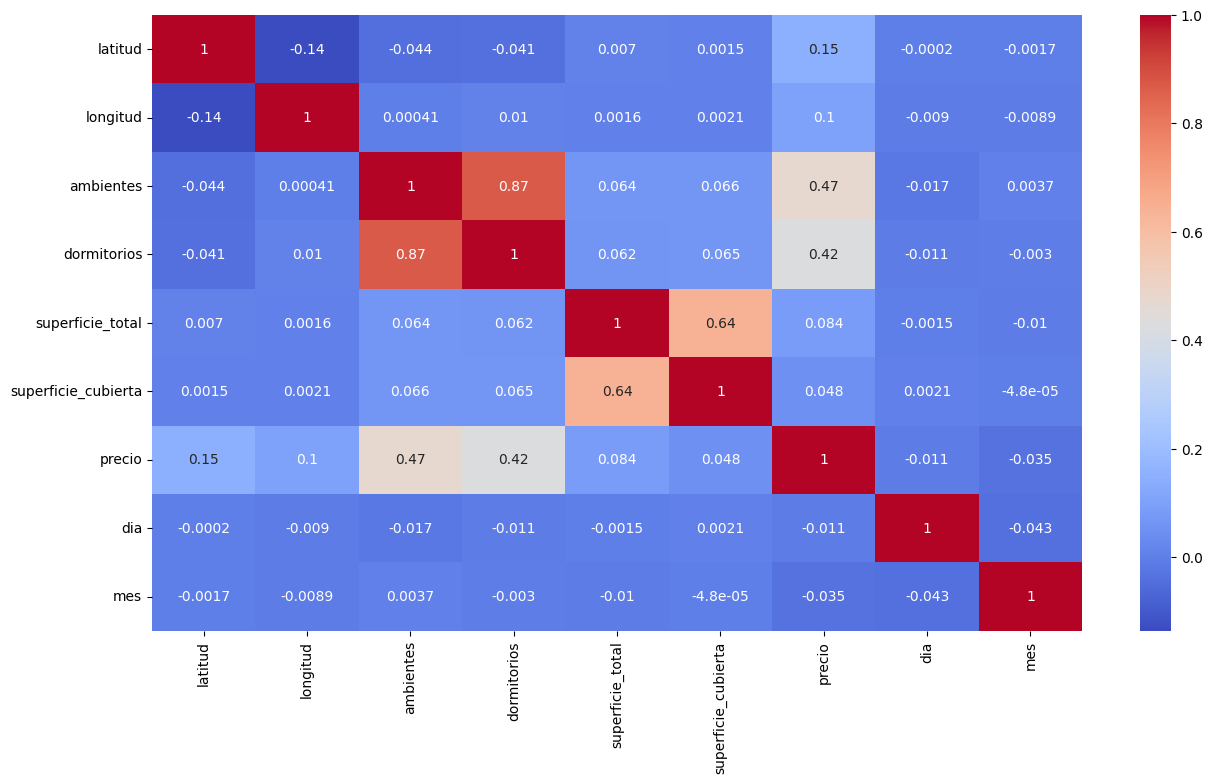

In [50]:
# Grafico la matriz de correlación en un Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(matriz_corr, annot=True, cmap="coolwarm")

Se ve cierta correlacion positiva media entre:
* Precio y Ambientes
* Precio y Dormitorios 

Naturalmente tambien vemos una correlacion mas fuerte entre:
* Superficie total y cubierta
* Ambientes y Dormitorios.

A continuacion exploremos estas correlaciones en mas detalle.

#### Dispersograma ambientes vrs precio

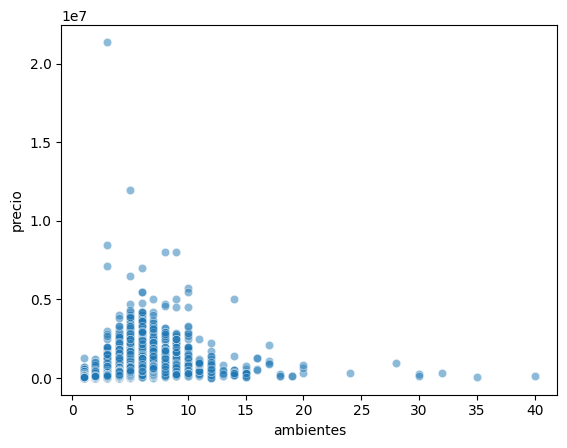

In [51]:
grf = sns.scatterplot(data=df, x="ambientes", y="precio", alpha=0.5)

#### Dispersograma dormitorios vrs precio

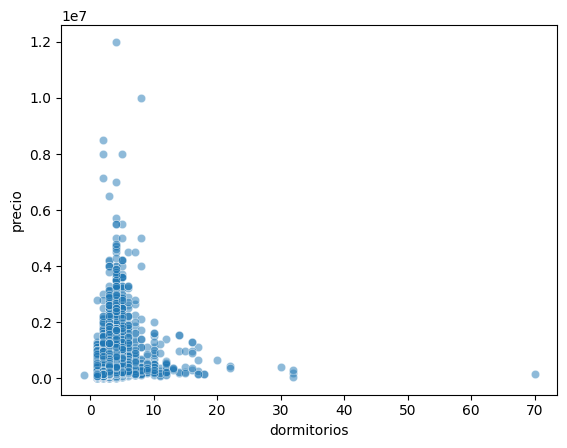

In [52]:
grf = sns.scatterplot(data=df, x="dormitorios", y="precio", alpha=0.5)

#### Dispersograma ambientes vrs superficie_total

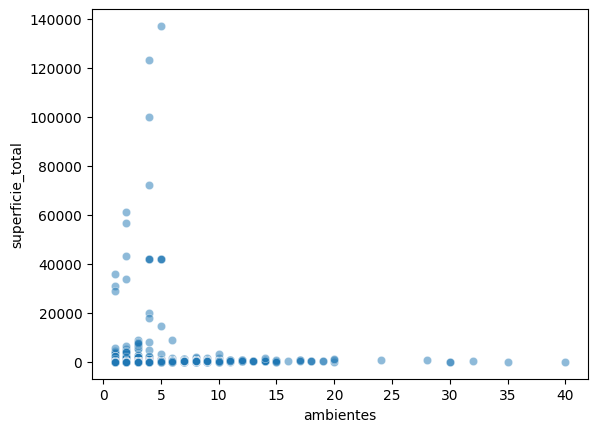

In [53]:
grf = sns.scatterplot(data=df, x="ambientes", y="superficie_total", alpha=0.5)

#### Dispersograma ambientes vrs superficie_cubierta

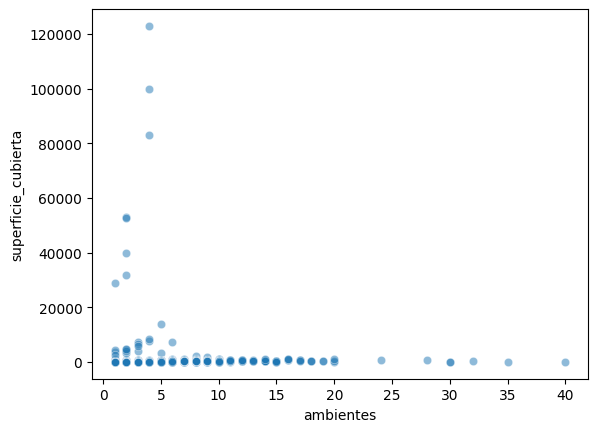

In [54]:
grf = sns.scatterplot(data=df, x="ambientes", y="superficie_cubierta", alpha=0.5)

#### Dispersograma ambientes vrs dormitorios

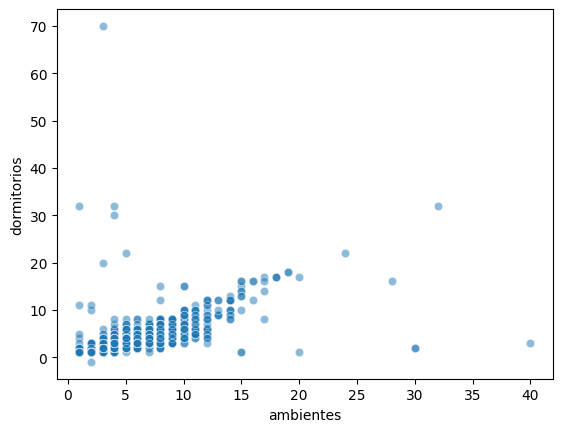

In [55]:
grf = sns.scatterplot(data=df, x="ambientes", y="dormitorios", alpha=0.5)

#### Dispersograma superficie_total vrs superficie_cubierta

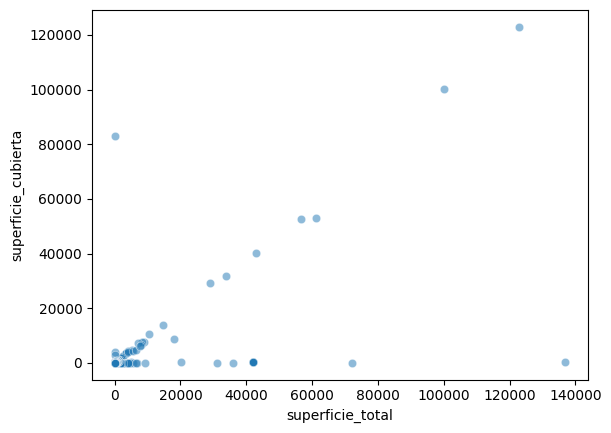

In [56]:
grf = sns.scatterplot(data=df, x="superficie_total", y="superficie_cubierta", alpha=0.5)

### Veamos la relacion entre algunos de los otros features

#### Dispersograma barrio vrs tipo

In [58]:
pd.crosstab(df["barrio"], df["tipo"])

tipo,Casa,Departamento,PH
barrio,,,
Abasto,5,182,5
Agronomía,26,108,85
Almagro,31,3007,313
Balvanera,19,1986,161
Barracas,81,831,180
Barrio Norte,19,2329,39
Belgrano,190,6528,199
Boca,23,268,49
Boedo,78,789,256


**c) Valores atípicos:** analizar la existencia de valores atípicos
* Detectar valores atípicos en los datos tanto en forma univariada como
multivariada. Realizar gráficos que permitan visualizar los valores atípicos.
* Explicar qué características poseen los datos atípicos detectados.
* Decidir el tratamiento a aplicar sobre los mismos.
* Analizar la relación entre el precio de venta y los metros de superficie ¿hay
valores atípicos que no se detectaron previamente?

### Precio

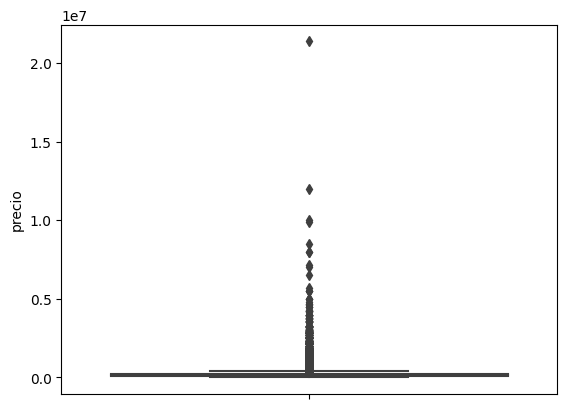

In [59]:
# sns.set(rc={"figure.figsize":(10, 45)})
sns.boxplot(y=df.precio)
plt.show()

Verificacion de valores atipicos

In [60]:
# Outliers
outlier = df[df["precio"] > 2500000]
outlier

,latitud,longitud,barrio,sub_barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
46,-34.576741,-58.404830,Palermo,Palermo Chico,Departamento,NaN,4.0,400.0,NaN,2700000.0,9,9
187,-34.605781,-58.376705,San Nicolás,NaN,Departamento,NaN,NaN,10500.0,10500.0,9900000.0,9,9
838,-34.577484,-58.405751,Palermo,Palermo Chico,Departamento,5.0,3.0,535.0,220.0,2800000.0,20,9
851,-34.567172,-58.430634,Palermo,NaN,Departamento,5.0,4.0,390.0,390.0,2900000.0,20,9
1403,-34.590923,-58.384214,Recoleta,NaN,Departamento,9.0,4.0,668.0,668.0,5000000.0,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...
71260,-34.567114,-58.441770,Palermo,NaN,Casa,7.0,8.0,1000.0,900.0,4000000.0,16,12
72828,-34.574818,-58.421237,Palermo,NaN,Departamento,5.0,3.0,400.0,400.0,2890000.0,4,5
72831,-34.576855,-58.410590,Palermo,Palermo Chico,Departamento,8.0,4.0,489.0,454.0,2950000.0,4,5
77228,-34.581524,-58.403588,Palermo,NaN,Departamento,10.0,6.0,520.0,500.0,3300000.0,8,5


In [61]:
print(df["precio"].describe())

count    7.768700e+04
mean     2.120536e+05
std      2.814634e+05
min      5.000000e+03
25%      9.500000e+04
50%      1.400000e+05
75%      2.300000e+05
max      2.140000e+07
Name: precio, dtype: float64


Outliers viviendas segun precios

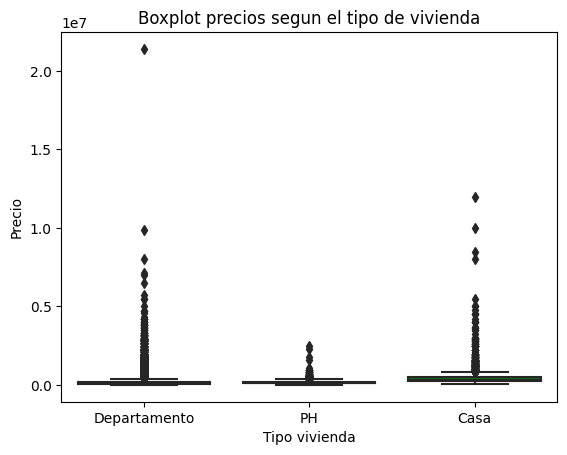

In [62]:
# Viviendas segun precios
# sns.set(rc={"figure.figsize":(10, 45)})
sns_boxplot_fare_pclass = sns.boxplot(
    x="tipo", y="precio", data=df, palette=["r", "b", "g"]
).set(
    title="Boxplot precios segun el tipo de vivienda",
    xlabel="Tipo vivienda",
    ylabel="Precio",
)

### Precio

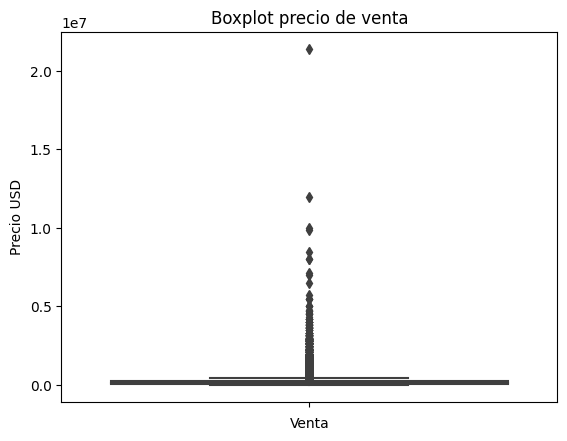

In [63]:
plt.figure(dpi=100)
sns_boxplot_price = sns.boxplot(y="precio", data=df).set(
    title="Boxplot precio de venta", xlabel="Venta", ylabel="Precio USD"
)

+ Outlier

In [64]:
df[df["precio"] > 20000000]

,latitud,longitud,barrio,sub_barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
11355,-34.616044,-58.458621,Caballito,NaN,Departamento,3.0,NaN,68.0,64.0,21400000.0,25,1


+ Es el mismo outlier de antes, es la venta de un departamento

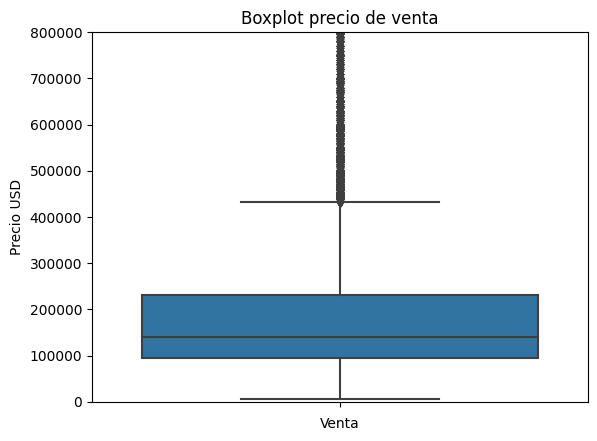

In [65]:
plt.figure(dpi=100)
sns_boxplot_price = sns.boxplot(y="precio", data=df)
sns_boxplot_price = sns_boxplot_price.set(
    title="Boxplot precio de venta",
    xlabel="Venta",
    ylabel="Precio USD",
    ylim=(0, 800000),
)

### Precio segun el tipo de propiedad

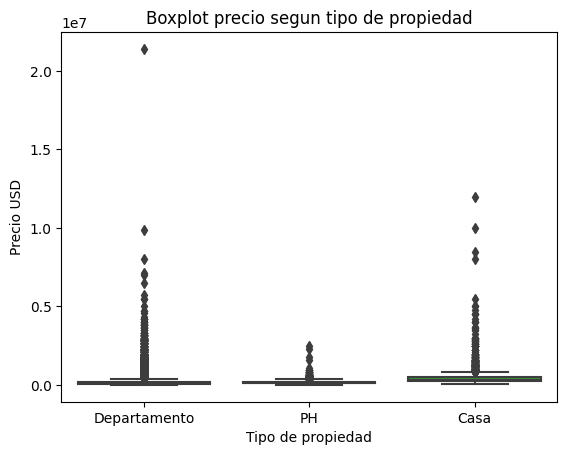

In [66]:
plt.figure(dpi=100)
sns_boxplot_price = sns.boxplot(x="tipo", y="precio", data=df).set(
    title="Boxplot precio segun tipo de propiedad",
    xlabel="Tipo de propiedad",
    ylabel="Precio USD",
)

+ Hay un outlier muy lejano en departamento

In [67]:
df_depto = df[df["tipo"] == "Departamento"]
df_depto[df_depto["precio"] > 20000000]

,latitud,longitud,barrio,sub_barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
11355,-34.616044,-58.458621,Caballito,NaN,Departamento,3.0,NaN,68.0,64.0,21400000.0,25,1


+ Hay 4 outliers mas alejados en casa

In [68]:
df_casa = df[df["tipo"] == "Casa"]
df_casa[df_casa["precio"] > 6000000]

,latitud,longitud,barrio,sub_barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
16183,-34.572494,-58.462433,Belgrano,NaN,Casa,5.0,4.0,3197.0,3367.0,12000000.0,26,3
27275,-34.565947,-58.442326,Belgrano,NaN,Casa,9.0,5.0,1763.0,1763.0,8000000.0,12,5
28557,-34.608300,-58.371200,Monserrat,NaN,Casa,3.0,2.0,225.0,93.0,8500000.0,17,2
56799,-34.593634,-58.377164,Retiro,NaN,Casa,NaN,8.0,1166.0,1485.0,10000000.0,17,9


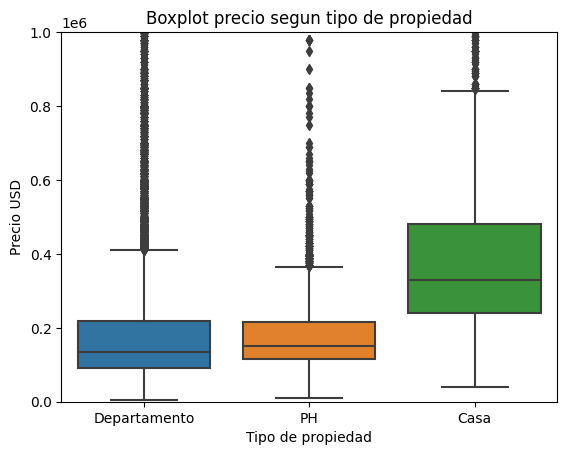

In [69]:
plt.figure(dpi=100)
sns_boxplot_price = sns.boxplot(x="tipo", y="precio", data=df)
sns_boxplot_price = sns_boxplot_price.set(
    title="Boxplot precio segun tipo de propiedad",
    xlabel="Tipo de propiedad",
    ylabel="Precio USD",
    ylim=(0, 1000000),
)

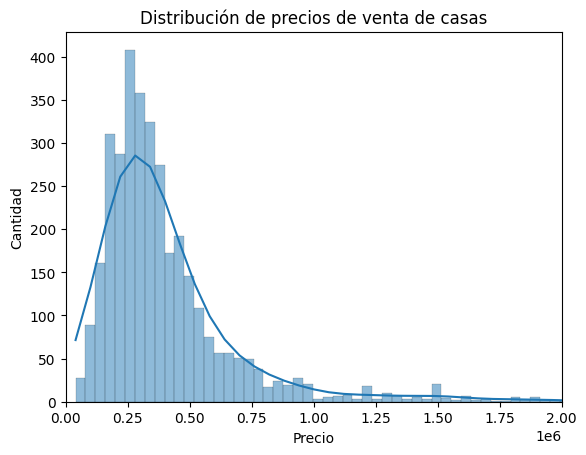

In [70]:
plt.figure(dpi=100)
h_casa = sns.histplot(df_casa["precio"], bins=300, kde=True)
h_casa = h_casa.set(
    title="Distribución de precios de venta de casas",
    xlim=(0, 2000000),
    xlabel="Precio",
    ylabel="Cantidad",
)

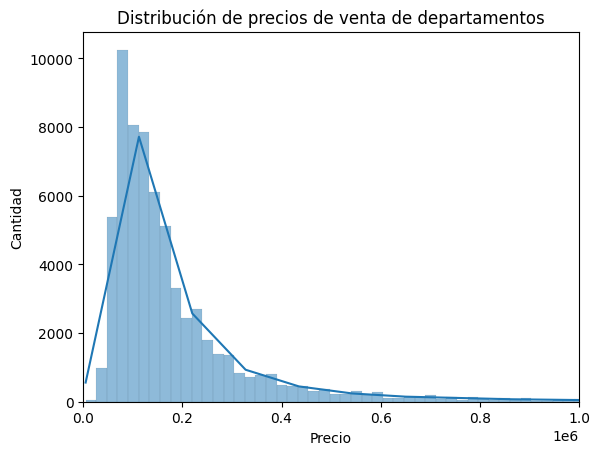

In [71]:
plt.figure(dpi=100)
h_depto = sns.histplot(df_depto["precio"], bins=1000, kde=True)
h_depto = h_depto.set(
    title="Distribución de precios de venta de departamentos",
    xlim=(0, 1000000),
    xlabel="Precio",
    ylabel="Cantidad",
)

In [72]:
df_ph = df[df["tipo"] == "PH"]

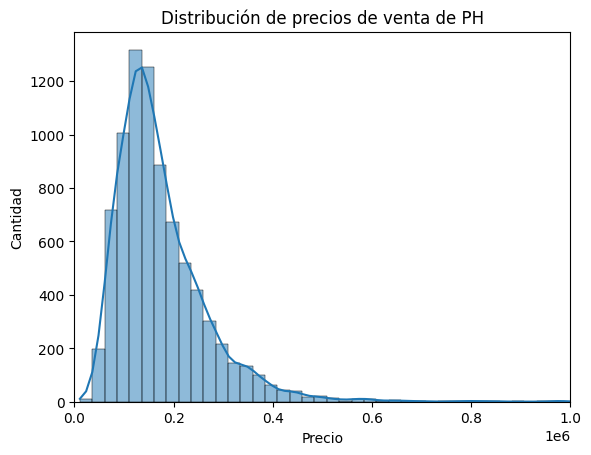

In [73]:
plt.figure(dpi=100)
h_ph = sns.histplot(df_ph["precio"], bins=100, kde=True)
h_ph = h_ph.set(
    title="Distribución de precios de venta de PH",
    xlim=(0, 1000000),
    xlabel="Precio",
    ylabel="Cantidad",
)

#### Con log

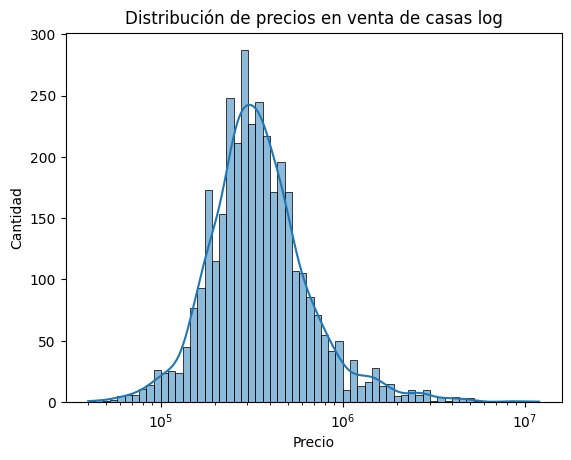

In [74]:
plt.figure(dpi=100)
h_casa2 = sns.histplot(df_casa["precio"], kde=True, log_scale=True)
h_casa2 = h_casa2.set(
    title="Distribución de precios en venta de casas log",
    xlabel="Precio",
    ylabel="Cantidad",
)

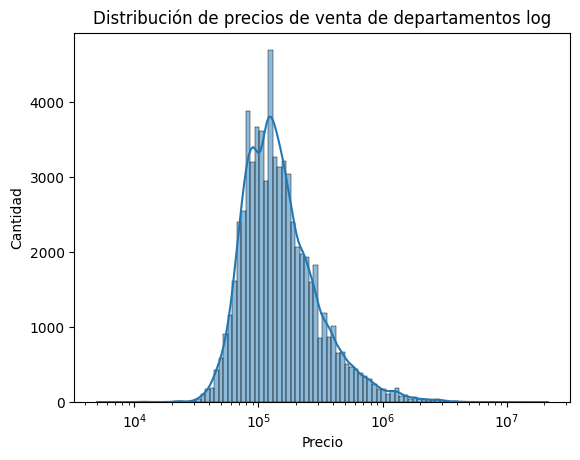

In [75]:
plt.figure(dpi=100)
h_depto2 = sns.histplot(df_depto["precio"], bins=100, kde=True, log_scale=True)
h_depto2 = h_depto2.set(
    title="Distribución de precios de venta de departamentos log",
    xlabel="Precio",
    ylabel="Cantidad",
)

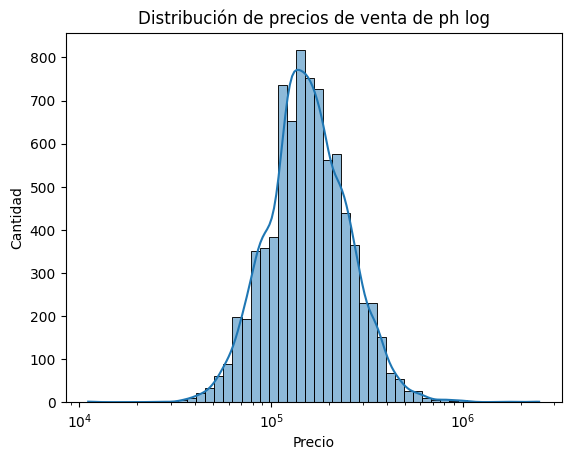

In [76]:
plt.figure(dpi=100)
h_ph2 = sns.histplot(df_ph["precio"], bins=50, kde=True, log_scale=True)
h_ph2 = h_ph2.set(
    title="Distribución de precios de venta de ph log",
    xlabel="Precio",
    ylabel="Cantidad",
)

#### Ambientes

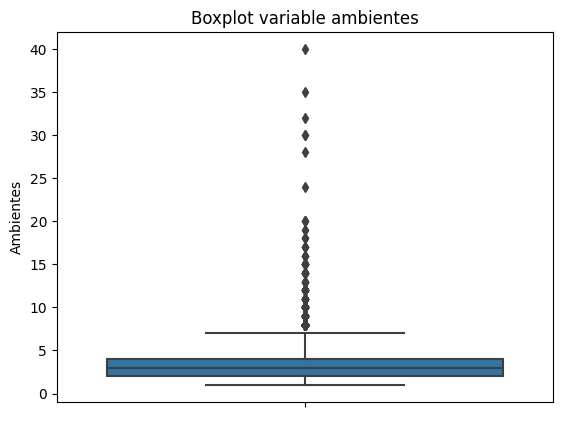

In [77]:
# Boxplot de la variable ambientes
grf_box = sns.boxplot(y="ambientes", data=df).set(
    title="Boxplot variable ambientes", xlabel=" ", ylabel="Ambientes"
)

Podemos observar multiples outliers, muchos de ellos extremos

In [78]:
outlier_rooms = df[df.ambientes > 25]
outlier_rooms

,latitud,longitud,barrio,sub_barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
3936,-34.616391,-58.456038,Caballito,NaN,Departamento,30.0,2.0,79.0,79.0,230000.0,15,3
9728,-34.649872,-58.483012,Parque Avellaneda,NaN,PH,30.0,2.0,72.0,60.0,123500.0,7,2
16946,-34.633236,-58.480313,Floresta,NaN,PH,32.0,32.0,535.0,435.0,300000.0,3,8
27766,-34.642037,-58.438995,Parque Chacabuco,NaN,Departamento,35.0,NaN,37.0,33.0,67000.0,24,3
60385,-34.588742,-58.422459,Palermo,NaN,Departamento,40.0,3.0,75.0,68.0,145000.0,18,11
65311,-34.570959,-58.458106,Belgrano,NaN,Casa,28.0,16.0,845.0,845.0,950000.0,5,5


Vemos que salvo el hotel y la casa inglesa, los demas no son posibles. Procedemos a borrarlos.

In [79]:
# Seleccionamos todos menos el hotel y la casa inglesa
idx = outlier_rooms.iloc[[2,5],].index
# Y los eliminamos
df.drop(idx, inplace=True)

Volvamos a ver el boxplot luego de eliminar los outliers.

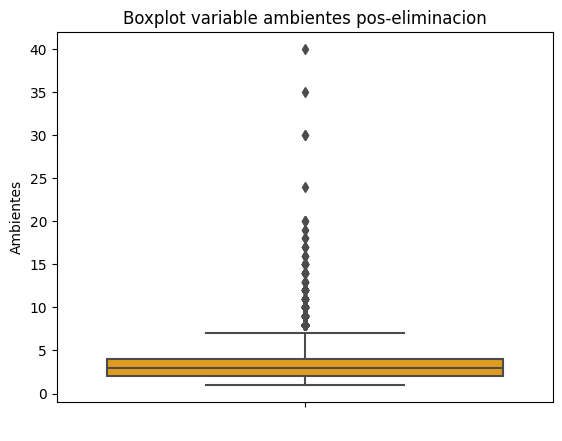

In [80]:
# Volvemos a graficar un boxplot despues de eliminar algunos outliers
grf_box = sns.boxplot(y="ambientes", data=df, color='orange').set(
    title="Boxplot variable ambientes pos-eliminacion", xlabel=" ", ylabel="Ambientes"
)

#### Dormitorios

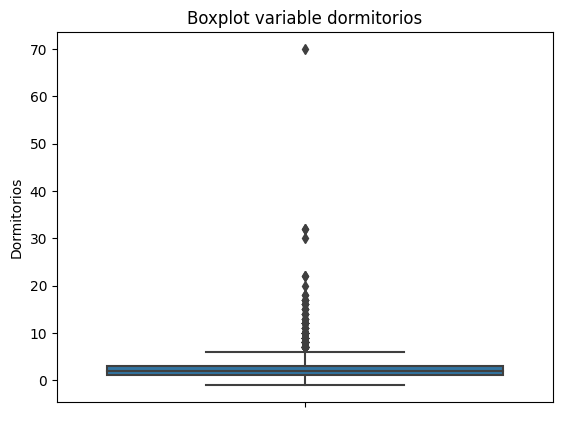

In [81]:
# Boxplot de la variable dormitorios
grf_box = sns.boxplot(y="dormitorios", data=df).set(
    title="Boxplot variable dormitorios", xlabel=" ", ylabel="Dormitorios"
)

Nuevamente vemos multiples outliers, algunos de ellos extremos.

In [82]:
outlier_bedrooms = df[df.dormitorios > 25]
outlier_bedrooms

,latitud,longitud,barrio,sub_barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
9014,-34.608645,-58.485619,Villa del Parque,NaN,Departamento,4.0,32.0,83.0,75.0,189000.0,14,3
9321,-34.630186,-58.389156,Parque Patricios,NaN,Departamento,1.0,32.0,32.0,32.0,52000.0,16,10
16261,-34.591110,-58.400685,Recoleta,NaN,Departamento,4.0,30.0,148.0,138.0,380000.0,26,3
17914,-34.646632,-58.497902,Villa Luro,NaN,Departamento,3.0,70.0,NaN,70.0,135000.0,24,9


Vemos que ninguno de los casos es posible. Procedemos a eliminarlos.

In [83]:
# Seleccionamos todos menos el hotel
idx = outlier_bedrooms.index
# Y los eliminamos
df.drop(idx, inplace=True)

Nos fijamos nuevamente en el boxplot luego de la eliminacion de los outliers extremos.

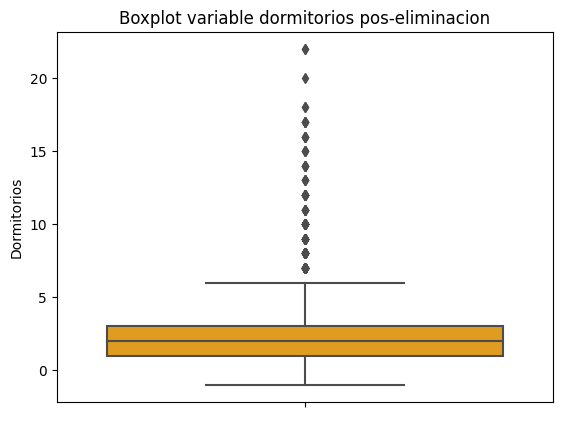

In [84]:
# Volvemos a graficar un boxplot despues de eliminar algunos outliers
grf_box = sns.boxplot(y="dormitorios", data=df, color='orange').set(
    title="Boxplot variable dormitorios pos-eliminacion", xlabel=" ", ylabel="Dormitorios"
)

#### Superficie Total

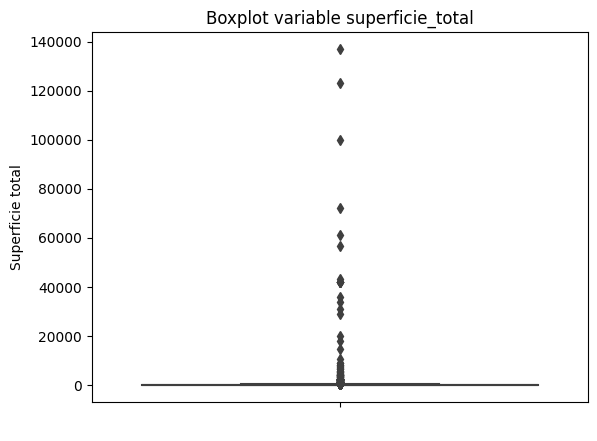

In [85]:
# Boxplot de la variable superficie total
grf_box = sns.boxplot(y="superficie_total", data=df).set(
    title="Boxplot variable superficie_total", xlabel=" ", ylabel="Superficie total"
)

Se observa una gran cantidad de outliers y muy extremos

In [86]:
# Buscamos observaciones mayores a 5mil m2
outlier_sfc_total = df[df.superficie_total > 5000]
# Verificamos si son valores posibles
outlier_sfc_total

,latitud,longitud,barrio,sub_barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
187,-34.605781,-58.376705,San Nicolás,NaN,Departamento,NaN,NaN,10500.0,10500.0,9900000.0,9,9
13714,-34.578917,-58.429373,Palermo,NaN,Departamento,2.0,1.0,61130.0,53030.0,225000.0,29,5
13777,-34.600113,-58.403649,Balvanera,NaN,Departamento,2.0,1.0,33800.0,31670.0,66000.0,29,5
15907,-34.588175,-58.396261,Recoleta,NaN,Departamento,1.0,NaN,36000.0,30.0,90000.0,5,2
17880,-34.614279,-58.361092,Caballito,NaN,Departamento,2.0,1.0,5312.0,4809.0,145000.0,24,9
19820,-34.587320,-58.401556,Barrio Norte,NaN,Departamento,2.0,1.0,56740.0,52540.0,175000.0,11,3
21958,-34.550093,-58.483034,Saavedra,NaN,Departamento,2.0,1.0,43086.0,40038.0,114000.0,18,8
23611,-34.579163,-58.455725,Colegiales,NaN,Departamento,1.0,NaN,31000.0,26.0,51100.0,5,10
23924,-34.599421,-58.386867,Barrio Norte,NaN,Departamento,5.0,3.0,137000.0,135.0,390000.0,1,7
27553,-34.629203,-58.437124,Caballito,NaN,PH,3.0,2.0,5736.0,57.0,169000.0,24,3


In [87]:
# Vemos que hay valores que posiblemente tengan ceros de mas
idx = outlier_sfc_total.index
# Y procedemos a borrarlos, mas adelante se podria intentar salvarlos
df.drop(idx, inplace=True)

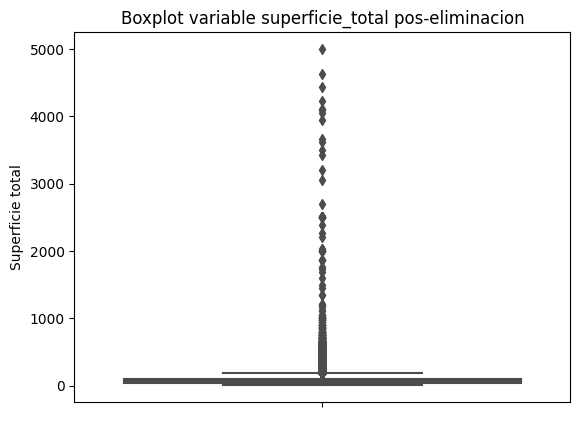

In [88]:
# Volvemos a graficar un boxplot despues de eliminar algunos outliers
grf_box = sns.boxplot(y="superficie_total", data=df, color='orange').set(
    title="Boxplot variable superficie_total pos-eliminacion", xlabel=" ", ylabel="Superficie total"
)

Elegimos un umbral que nos parezca razonable, despues de haber visto mejor los datos, para buscar outliers invalidos.

In [89]:
# Buscamos observaciones mayores a mil m2 pero menos de 5 ambientes
outlier_sfc_rooms = df[
    df.apply(
        lambda x: x["superficie_total"] > 1000
        and x["ambientes"] < 5,
        axis=1,
    )
]
# Verificamos si son valores posibles
outlier_sfc_rooms

,latitud,longitud,barrio,sub_barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
344,-34.584521,-58.424260,Palermo,NaN,Departamento,2.0,1.0,2032.0,37.0,87000.0,17,12
6205,-34.634196,-58.465152,Flores,NaN,Departamento,1.0,1.0,4428.0,31.0,58552.0,8,2
6410,-34.554356,-58.458076,Belgrano,NaN,Departamento,2.0,1.0,2500.0,51.0,189850.0,8,2
6419,-34.557903,-58.452293,Belgrano,NaN,Departamento,4.0,3.0,5000.0,109.0,418000.0,8,2
6505,-34.611660,-58.393440,Balvanera,NaN,Departamento,2.0,1.0,2383.0,37.0,64000.0,8,2
6549,-34.628565,-58.445791,Caballito,NaN,Departamento,4.0,3.0,2000.0,162.0,449900.0,8,2
6728,-34.573000,-58.481100,Villa Urquiza,NaN,Departamento,1.0,NaN,3660.0,33.0,98000.0,8,2
6730,-34.573375,-58.480012,Villa Urquiza,NaN,Departamento,2.0,1.0,3500.0,60.0,169000.0,8,2
11162,-34.563005,-58.453674,Belgrano,NaN,Departamento,3.0,2.0,2500.0,66.0,289500.0,13,3
11168,-34.563005,-58.453674,Belgrano,NaN,Departamento,3.0,2.0,2500.0,66.0,299900.0,13,3


In [90]:
# Vemos que hay valores que posiblemente tengan ceros de mas
idx = outlier_sfc_rooms.index
# Y procedemos a borrarlos, mas adelante se podria intentar salvarlos
df.drop(idx, inplace=True)

Volvemos a realizar el mismo proceso, con un nuevo umbral para intentar detectar otros outliers invalidos.

In [91]:
# Buscamos observaciones mayores a 500 m2 pero menos de 4 ambientes
outlier_sfc_rooms = df[
    df.apply(
        lambda x: x["superficie_total"] > 500
        and x["ambientes"] < 4,
        axis=1,
    )
]
# Verificamos si son valores posibles
outlier_sfc_rooms

,latitud,longitud,barrio,sub_barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
9025,-34.613200,-58.471100,Villa General Mitre,NaN,PH,3.0,4.0,800.0,720.0,495000.0,15,8
26343,-34.646590,-58.519538,Liniers,NaN,PH,3.0,2.0,534.0,340.0,440000.0,8,6
33349,-34.621995,-58.508856,Floresta,NaN,Departamento,3.0,2.0,645.0,59.0,93000.0,7,8
39739,-34.580700,-58.413795,Palermo,NaN,Departamento,2.0,1.0,725.0,65.0,349000.0,9,1
40145,-34.580496,-58.429956,Palermo,NaN,Casa,1.0,NaN,1000.0,900.0,300000.0,8,3
41140,-34.607533,-58.477092,Villa General Mitre,NaN,Departamento,3.0,2.0,560.0,416.0,499900.0,20,3
73753,-34.617351,-58.499418,Monte Castro,NaN,Casa,3.0,2.0,525.0,355.0,400000.0,23,4
77411,-34.645581,-58.472496,Parque Avellaneda,NaN,Casa,3.0,2.0,526.0,474.0,400000.0,5,1


In [92]:
# Vemos que hay valores que posiblemente tengan ceros de mas
idx = outlier_sfc_rooms.index
# Y procedemos a borrarlos, mas adelante se podria intentar salvarlos
df.drop(idx, inplace=True)

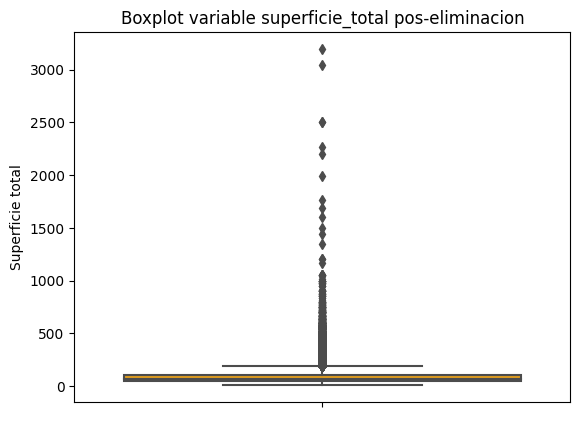

In [93]:
# Volvemos a graficar un boxplot una ultima vez luego de eliminar mas propiedades
grf_box = sns.boxplot(y="superficie_total", data=df, color='orange').set(
    title="Boxplot variable superficie_total pos-eliminacion", xlabel=" ", ylabel="Superficie total"
)

#### Superficie Cubierta

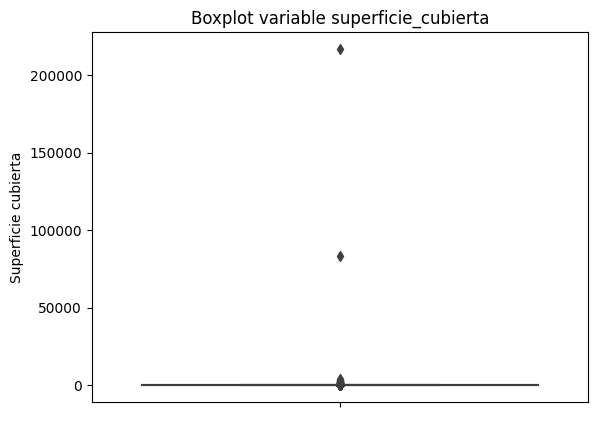

In [94]:
# Boxplot de la variable superficie cubierta
grf_box = sns.boxplot(y="superficie_cubierta", data=df).set(
    title="Boxplot variable superficie_cubierta",
    xlabel=" ",
    ylabel="Superficie cubierta",
)

In [95]:
# Buscamos observaciones mayores a 3mil m2
outlier_sfc_cov = df[df.superficie_cubierta > 3000]
outlier_sfc_cov

,latitud,longitud,barrio,sub_barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
292,-34.637026,-58.426283,Parque Chacabuco,NaN,Casa,NaN,NaN,NaN,217000.0,250000.0,17,12
16183,-34.572494,-58.462433,Belgrano,NaN,Casa,5.0,4.0,3197.0,3367.0,12000000.0,26,3
35680,-34.604362,-58.392366,Barrio Norte,NaN,Departamento,4.0,NaN,83.0,83000.0,155000.0,25,7
60077,-34.579394,-58.453519,Colegiales,NaN,Departamento,3.0,2.0,41.0,3837.0,83000.0,4,11


In [96]:
# Vemos que hay valores que posiblemente tengan ceros de mas
idx = outlier_sfc_cov.index
# Y procedemos a borrarlos, mas adelante se podria intentar salvarlos
df.drop(idx, inplace=True)

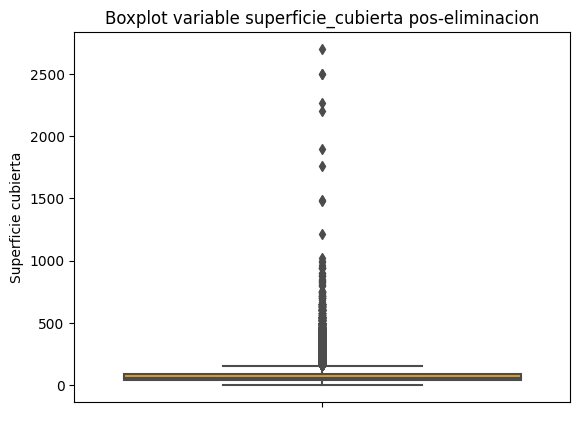

In [97]:
# Volvemos a graficar un boxplot despues de eliminar algunos outliers
grf_box = sns.boxplot(y="superficie_cubierta", data=df, color='orange').set(
    title="Boxplot variable superficie_cubierta pos-eliminacion",
    xlabel=" ",
    ylabel="Superficie cubierta",
)

In [98]:
# Buscamos observaciones mayores a mil m2 cubiertos pero menos de 5 ambientes
outlier_covsfc_rooms = df[
    df.apply(
        lambda x: x["superficie_cubierta"] > 1000
        and x["ambientes"] < 5,
        axis=1,
    )
]
# Verificamos si son valores posibles
outlier_covsfc_rooms

,latitud,longitud,barrio,sub_barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
73555,-34.630704,-58.400901,Parque Patricios,NaN,Departamento,1.0,NaN,31.0,2700.0,71500.0,27,10


In [99]:
# Vemos que hay un valor que no es posible
idx = outlier_covsfc_rooms.index
# Y procedemos a borrarlo
df.drop(idx, inplace=True)

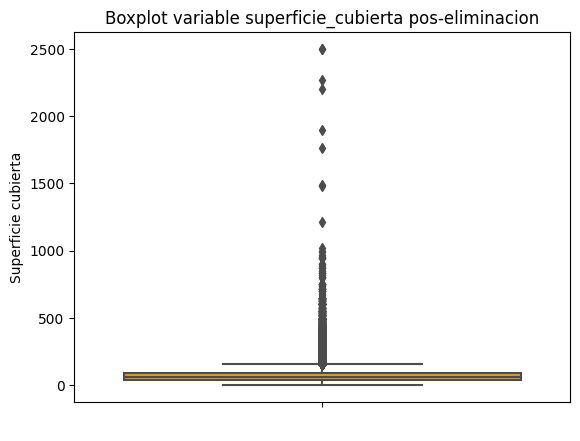

In [100]:
# Volvemos a graficar un boxplot una ultima despues de eliminar algunos outliers
grf_box = sns.boxplot(y="superficie_cubierta", data=df, color='orange').set(
    title="Boxplot variable superficie_cubierta pos-eliminacion",
    xlabel=" ",
    ylabel="Superficie cubierta",
)

**b) Datos Faltantes:** analizar la presencia de datos faltantes en el dataset
* Realizar análisis de datos faltantes a nivel de columna. Graficar para cada variable
el porcentaje de datos faltantes con respecto al total del dataset
* Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de
datos faltantes de cada registro. Realizar un gráfico que permita conocer la
proporción de faltantes por fila en el dataset.
* Determinar, de ser posible, estrategias para reparar los valores faltantes.
* En caso de realizar imputaciones comparar las distribuciones de cada atributo
reparado con la distribución anterior a la imputación de los datos faltantes.

<h4 align="center"><b> Realizar análisis de datos faltantes a nivel de columna. Graficar para cada variable
el porcentaje de datos faltantes con respecto al total del dataset </b></h4>

#### Veamos la distribucion de datos faltantes del dataset en general

In [101]:
na_ratio_column = pd.DataFrame()
na_ratio_column["Percent"] = ((df.isnull().sum() / len(df)) * 100).sort_values(
    ascending=False
)
na_ratio_column["Count"] = (df.isnull().sum()).sort_values(ascending=False)

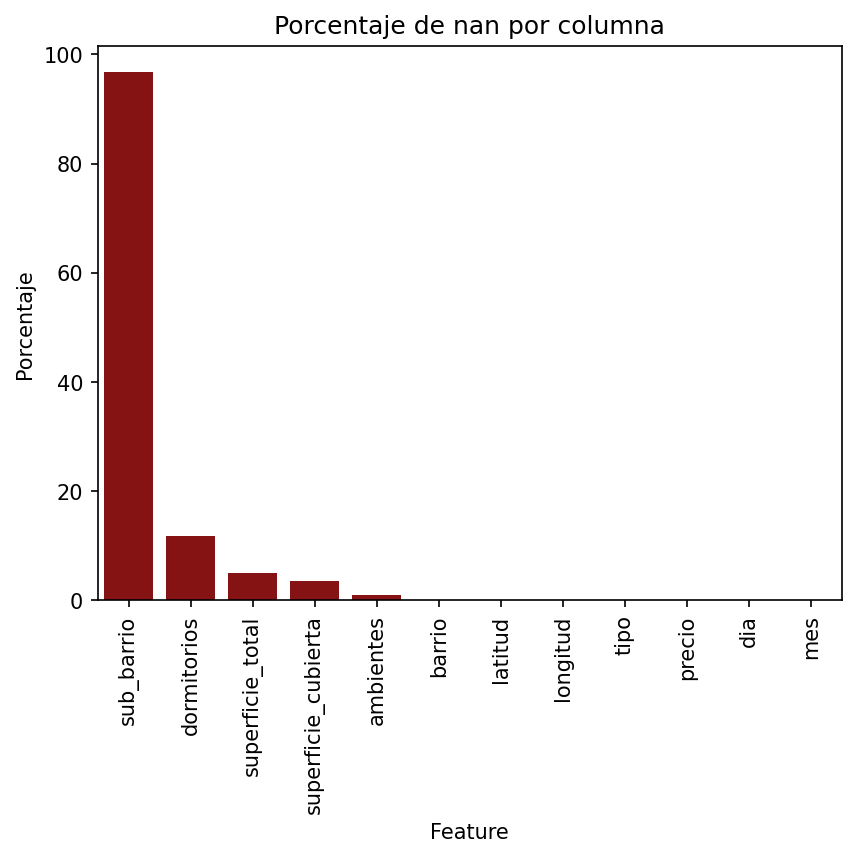

In [102]:
eje_x = na_ratio_column.index
eje_y = list(na_ratio_column["Percent"])

plt.figure(dpi=150)
sns_bar_plot = sns.barplot(x=eje_x, y=eje_y, color=(0.6, 0, 0), alpha=1)
plt.ylabel("Porcentaje")
plt.xlabel("Feature")
plt.title("Porcentaje de nan por columna")
plt.xticks(rotation=90)
plt.show()

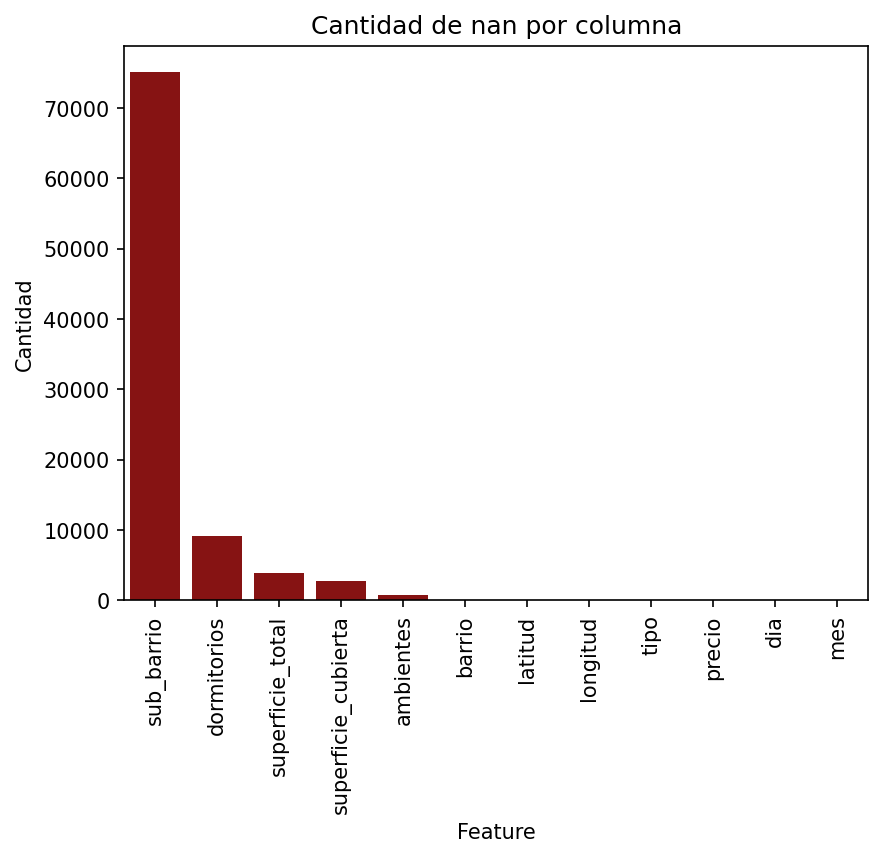

In [103]:
eje_x = na_ratio_column.index
eje_y = list(na_ratio_column["Count"])

plt.figure(dpi=150)
sns_bar_plot = sns.barplot(x=eje_x, y=eje_y, color=(0.6, 0, 0), alpha=1)
plt.ylabel("Cantidad")
plt.xlabel("Feature")
plt.title("Cantidad de nan por columna")
plt.xticks(rotation=90)
plt.show()

Vemos que los features con mayor porcentaje de datos faltantes son:
* sub_barrio
* dormitorios
* superficie_total
* superficie_cubierta
* ambientes

En ese orden, con sub_barrio teniendo la particularidad de estar casi 100% vacio.

<h4 align="center"><b> Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de datos faltantes de cada registro. Realizar un gráfico que permita conocer la proporción de faltantes por fila en el dataset </b></h4>

In [104]:
na_ratio_row = pd.DataFrame()
n_column = df.shape[1]
na_ratio_row["Percent"] = df.isnull().sum(axis=1) / n_column
na_ratio_row["Count"] = df.isnull().sum(axis=1)

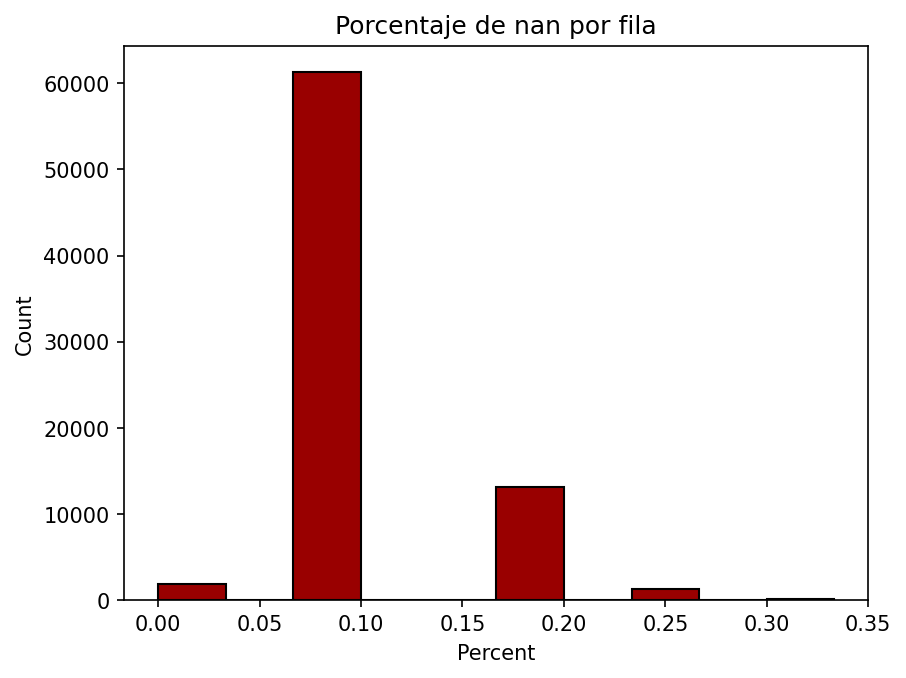

In [105]:
plt.figure(dpi=150)
sns.histplot(data=na_ratio_row, x="Percent", bins=10, color=(0.6, 0, 0), alpha=1)
plt.title("Porcentaje de nan por fila")
plt.show()

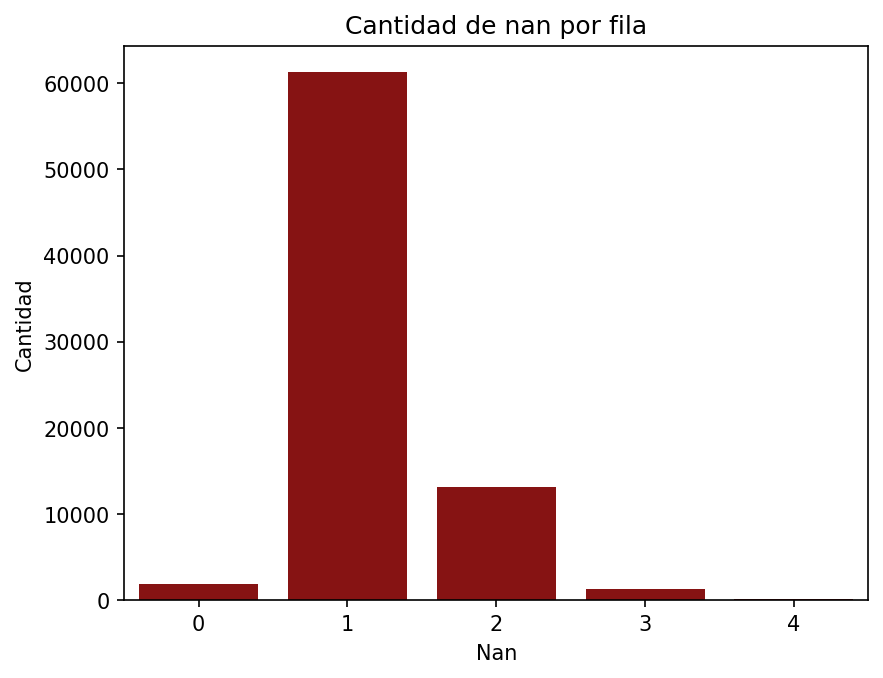

In [106]:
plt.figure(dpi=150)
sns.countplot(x="Count", data=na_ratio_row, color=(0.6, 0, 0), alpha=1)
plt.ylabel("Cantidad")
plt.xlabel("Nan")
plt.title("Cantidad de nan por fila")
plt.show()

#### Barrios

In [107]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
barrios_nan=round(df.isna().barrio.sum() / filas_totales * 100, 3)
print(f"El feature Barrios tiene: {barrios_nan} % filas nulas")

El feature Barrios tiene: 0.054 % filas nulas


Como el porcentaje de NaNs de place_l3 en relacion a las filas totales es del 0.54 ,eliminamos dichos registros

In [108]:
df = df[df["barrio"].notna()]

#### Ambientes

In [109]:
# Vemos cuantas filas tienen datos faltantes de ambientes
ambs_nan=df.ambientes.isnull().sum()
ambs_nan

797

In [110]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
print(f"El feature Ambientes tiene: {round(ambs_nan / filas_totales * 100, 3)} % filas nulas")

El feature Ambientes tiene: 1.028 % filas nulas


In [111]:
# Borramos las filas vacias
idx = df[df.ambientes.isnull()].index
df.drop(idx, inplace=True)

In [112]:
# Vemos si hay valores negativos
(df.ambientes <= 0).any()

False

Al tener un porcentaje relativamente pequeno de datos faltantes decidimos borrar los mismo en el feature Ambientes

#### Dormitorios

In [113]:
# Vemos cuantas filas tienen datos faltantes de dormitorios
dorms_nan=df.dormitorios.isnull().sum()
dorms_nan

8744

In [114]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
print(f"El feature Dormitorios tiene: {round(dorms_nan / filas_totales * 100, 3)} % filas nulas")

El feature Dormitorios tiene: 11.392 % filas nulas


In [115]:
# Vemos si hay valores negativos
(df.dormitorios <= 0).sum()

1

In [116]:
# Borramos el valor negativo
idx = df[df.dormitorios <= 0].index
df.drop(idx, inplace=True)

In [117]:
# Vemos cuantas propiedades tienen mas dormitorios que ambientes, lo cual no tiene sentido
df.apply(
    lambda row: True if row["ambientes"] < row["dormitorios"] else False, axis=1
).sum()

107

In [118]:
# Borramos las propiedades con mas dormitorios que ambientes
idx = df[
    df.apply(
        lambda row: True if row["ambientes"] < row["dormitorios"] else False, axis=1
    )
].index
df.drop(idx, inplace=True)

Por tener una cantidad considerablemente mayor de datos faltantes que el feature Ambientes y estar directamente relacionado con este, decidimos dejar los datos faltantes del feature Dormitorios e intentar repararlos mas adelante.

#### Superficie Total

In [119]:
# Vemos cuantas filas tienen datos faltantes de superficie_total
sup_total_nan=df.superficie_total.isnull().sum()
sup_total_nan

3768

In [120]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
print(f"El feature Superficie Total tiene: {round(sup_total_nan / filas_totales * 100, 3)} % filas nulas")

El feature Superficie Total tiene: 4.916 % filas nulas


In [121]:
# Vemos si hay valores negativos
(df.superficie_total <= 0).any()

False

#### Superficie Cubierta

In [122]:
# Vemos cuantas filas tienen datos faltantes de superficie_cubierta
sup_cub_nan=df.superficie_cubierta.isnull().sum()
sup_cub_nan

2601

In [123]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
print(f"El feature Superficie Cubierta tiene: {round(sup_cub_nan / filas_totales * 100, 3)} % filas nulas")

El feature Superficie Cubierta tiene: 3.394 % filas nulas


In [124]:
# Vemos si hay valores negativos
(df.superficie_cubierta <= 0).any()

False

In [125]:
# Vemos cuantas propiedades tienen mas superficie cubierta que total, lo cual no tiene sentido
df.apply(
    lambda row: True if row["superficie_total"] < row["superficie_cubierta"] else False,
    axis=1,
).sum()

142

In [126]:
# Borramos las propiedades con mas superficie cubierta que total
idx = df[
    df.apply(
        lambda row: True
        if row["superficie_total"] < row["superficie_cubierta"]
        else False,
        axis=1,
    )
].index
df.drop(idx, inplace=True)

<h4 align="center"><b> Division de dataset </b></h4>

In [ ]:
# DIVISION

<h4 align="center"><b> Determinar, de ser posible, estrategias para reparar los valores faltantes </b></h4>

#### Completamos las latitudes y longitudes con respecto a la media de su barrio.

In [127]:
medias_latitud = {}
medias_longitud = {}
valores_place = df.groupby(by=["barrio"]).mean().index
grupos = df.groupby(by=["barrio"]).mean()

In [128]:
for place in valores_place:
    medias_latitud[place] = grupos.latitud[place]
    medias_longitud[place] = grupos.longitud[place]

In [129]:
for place in valores_place:
    mask = (df["longitud"].isnull()) & (df["barrio"] == place)
    df.loc[mask, "longitud"] = medias_longitud[place]

In [130]:
for place in valores_place:
    mask = (df["latitud"].isnull()) & (df["barrio"] == place)
    df.loc[mask, "latitud"] = medias_latitud[place]

#### Completamos los datos faltantes de Dormitorios utilizando la moda segun la cantidad de ambientes, es decir, Imputacion Hot Deck

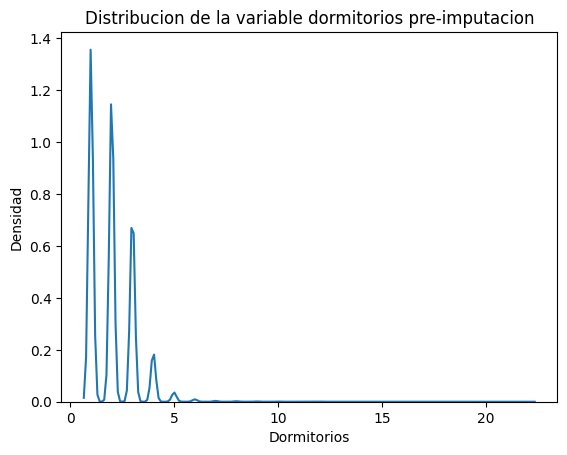

In [131]:
# Distribucion de la variable dormitorios antes de imputar o reparar datos
sns_hist = sns.kdeplot(data=df.dormitorios).set(
    title="Distribucion de la variable dormitorios pre-imputacion",
    xlabel="Dormitorios",
    ylabel="Densidad",
)

In [132]:
# Vamos a calcular la moda para el feature dormitorios dependiendo de cuantos ambientes tenga la propiedad
df_na = df[df.dormitorios.isna()]
unique_rooms = df_na.ambientes.unique().tolist()

for n in unique_rooms:
    # Calculamos la moda para cada valor unico de ambientes
    aux = df[df.ambientes == n]
    moda = aux.dormitorios.mode()
    if len(moda) == 0: # Si no se pudo calcular la moda la dejamos en NaN
        moda = [np.nan]
    # Le asignamos el valor que corresponda a cada celda de dormitorio que este vacia
    mask = ((df["dormitorios"].isnull())) & (df["ambientes"] == n)
    df.loc[mask, "dormitorios"] = moda[0]

In [133]:
# Volvemos a chequear que no tengamos datos faltantes luego de imputar
df.dormitorios.isnull().sum()

1

In [134]:
# Borramos el dato nulo
idx=df[df.dormitorios.isnull()].index
df.drop(index=idx, inplace=True)

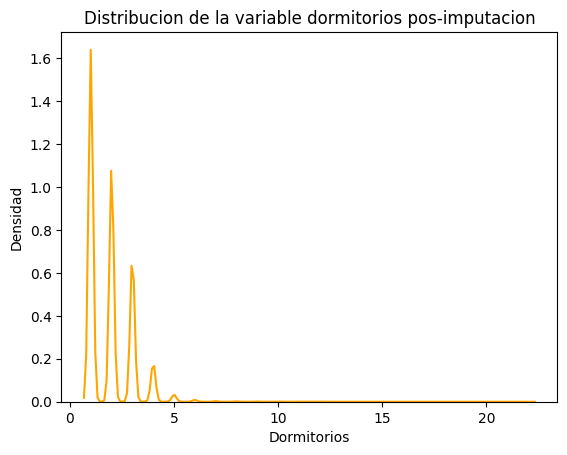

In [135]:
# Distribucion de la variable dormitorios despues de imputar o reparar datos
sns_hist = sns.kdeplot(data=df.dormitorios, color='orange').set(
    title="Distribucion de la variable dormitorios pos-imputacion",
    xlabel="Dormitorios",
    ylabel="Densidad",
)

Se observa que aumento la frecuencia del valor 1.

#### Completamos los datos faltantes de superficie total y cubierta utilizando regresion lineal segun el tipo de propiedad

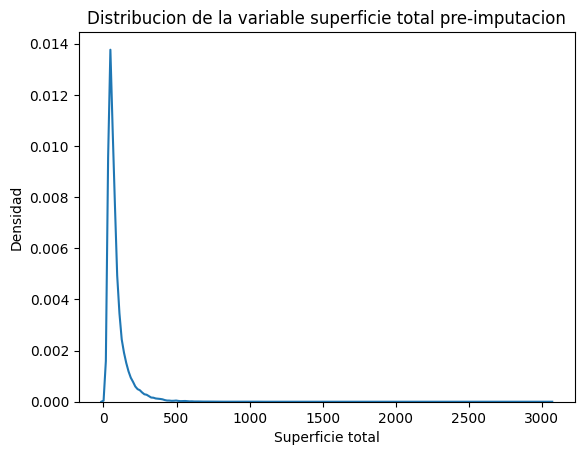

In [136]:
# Distribucion de la variable superficie_total antes de imputar o reparar datos
sns_hist = sns.kdeplot(data=df["superficie_total"]).set(
    title="Distribucion de la variable superficie total pre-imputacion",
    xlabel="Superficie total",
    ylabel="Densidad",
)

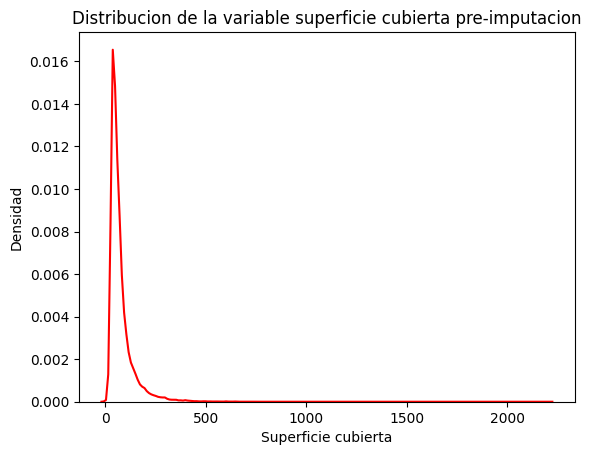

In [137]:
# Distribucion de la variable superficie_cubierta antes de imputar o reparar datos
sns_hist = sns.kdeplot(data=df["superficie_cubierta"], color="r").set(
    title="Distribucion de la variable superficie cubierta pre-imputacion",
    xlabel="Superficie cubierta",
    ylabel="Densidad",
)

In [138]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

# Tomamos las columnas de superficie total y cubierta para las propiedades separando por tipo de propiedad
columns = ["superficie_total", "superficie_cubierta"]
deptos = df.loc[(df["tipo"] == "Departamento"), columns].copy()
casas = df.loc[(df["tipo"] == "Casa"), columns].copy()
phs = df.loc[(df["tipo"] == "PH"), columns].copy()

# Imputamos los datos nuevos utilizando regresion lineal entre ambas features
lr = LinearRegression()
imp = IterativeImputer(
    estimator=lr,
    missing_values=np.nan,
    max_iter=20,
    imputation_order="random",
    skip_complete=True,
    verbose=0,
    random_state=0,
)
deptos = imp.fit_transform(deptos[columns])
casas = imp.fit_transform(casas[columns])
phs = imp.fit_transform(phs[columns])

# Ponemos los datos nuevamente en nuestro dataframe
df.loc[(df["tipo"] == "Departamento"), columns] = deptos
df.loc[(df["tipo"] == "Casa"), columns] = casas
df.loc[(df["tipo"] == "PH"), columns] = phs

In [139]:
df['superficie_total'] = df.superficie_total.apply(round)

In [140]:
df['superficie_cubierta'] = df.superficie_cubierta.apply(round)

In [141]:
# Volvemos a chequear que no tengamos datos faltantes luego de imputar
df.superficie_total.isnull().sum() == 0 and df.superficie_cubierta.isnull().sum() == 0

True

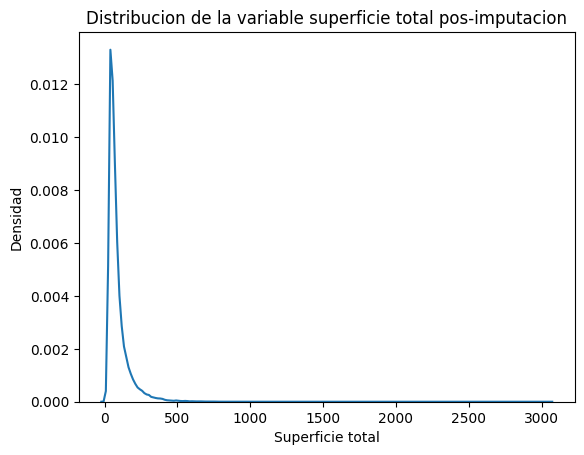

In [142]:
# Distribucion de la variable superficie_total despues de imputar o reparar datos
sns_hist = sns.kdeplot(data=df["superficie_total"]).set(
    title="Distribucion de la variable superficie total pos-imputacion",
    xlabel="Superficie total",
    ylabel="Densidad",
)

Observamos que la distribucion se mantiene practicamente igual luego de imputar.

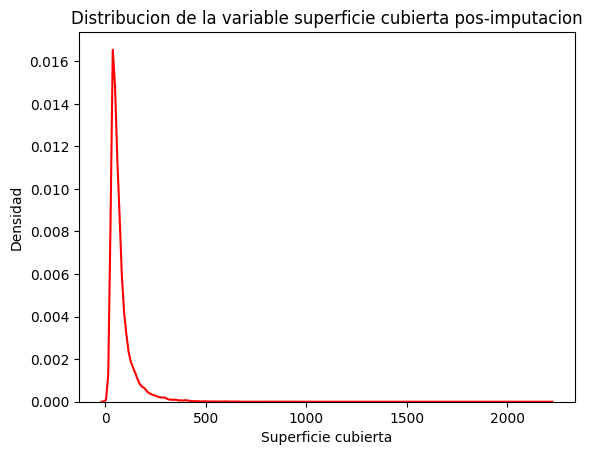

In [143]:
# Distribucion de la variable superficie_cubierta despues de imputar o reparar datos
sns_hist = sns.kdeplot(data=df["superficie_cubierta"], color="r").set(
    title="Distribucion de la variable superficie cubierta pos-imputacion",
    xlabel="Superficie cubierta",
    ylabel="Densidad",
)

Nuevamente se observa una distribucion muy similar luego de la imputacion.

In [144]:
# Volvemos a chequear cuantas propiedades tienen mas superficie cubierta que total, lo cual no tiene sentido
df.apply(
    lambda row: True if row["superficie_total"] < row["superficie_cubierta"] else False,
    axis=1,
).sum()

11

Vamos a buscar filas con una superficie mas grande que su superficie total, algo que no puede suceder, y las borramos.

In [145]:
# Vemos los datos que imputamos pero no tienen sentido
df[
    df.apply(
        lambda row: True
        if row["superficie_total"] < row["superficie_cubierta"]
        else False,
        axis=1,
    )
]

,latitud,longitud,barrio,sub_barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
2031,-34.601931,-58.411260,Abasto,NaN,Departamento,1.0,1.0,18,19,38000.0,13,1
3958,-34.633819,-58.504568,Villa Luro,NaN,Departamento,3.0,2.0,10,12,120000.0,15,3
11462,-34.602784,-58.397163,Balvanera,NaN,Departamento,1.0,1.0,18,19,45000.0,18,7
22871,-34.624384,-58.388260,Constitución,NaN,PH,1.0,1.0,30,31,65000.0,4,8
32437,-34.634265,-58.505317,Villa Luro,NaN,Departamento,3.0,2.0,10,12,120000.0,16,2
47259,-34.650566,-58.505336,Mataderos,NaN,PH,1.0,1.0,30,31,50000.0,19,6
47782,-34.650399,-58.391410,Barracas,NaN,PH,2.0,1.0,30,31,45000.0,15,9
63726,-34.655402,-58.486637,Mataderos,NaN,PH,1.0,1.0,22,26,60000.0,19,5
68415,-34.601833,-58.389437,Balvanera,NaN,PH,2.0,1.0,28,30,50000.0,7,1
68459,-34.626663,-58.423396,Boedo,NaN,Departamento,1.0,1.0,19,20,38000.0,7,1


In [146]:
# Borramos las propiedades con mas superficie cubierta que total
idx = df[
    df.apply(
        lambda row: True
        if row["superficie_total"] < row["superficie_cubierta"]
        else False,
        axis=1,
    )
].index
df.drop(idx, inplace=True)

In [147]:
tam_final=df.shape[0]
print(f"Se eliminaron: {tam_inicial-tam_final} filas en el pre-procesamiento, lo cual representa un {round((tam_inicial-tam_final) / tam_inicial * 100, 3)}%")

Se eliminaron: 1195 filas en el pre-procesamiento, lo cual representa un 1.538%


#### Agreguemos la comuna a la que corresponde cada propiedad

In [148]:
import geopandas as geopd
import rtree
from geopandas.tools import sjoin

dp_comunas = geopd.read_file("./Datasets/comunas.csv")
df_comunas = dp_comunas.copy()

In [149]:
# Tomamos solamente las columnas que necesitamos
df_comunas=df_comunas.filter(['COMUNAS','geometry'])
df_comunas.rename(columns={'COMUNAS':'comuna'},inplace=True)
# Casteamos las comunas a enteros para mayor comodidad
df_comunas['comuna']=df_comunas.comuna.astype(float)
df_comunas['comuna']=df_comunas.comuna.astype(int)

In [150]:
# Armamos un geodatafreame pasando longitud y latitud a variable de tipo punto
gdf = geopd.GeoDataFrame(
    df, geometry=geopd.points_from_xy(df.longitud, df.latitud))

# Unimos los dataframes asignando la comuna que le corresponde a cada punto segun su coordenada
join = gdf.sjoin(df_comunas, how="inner")
join.drop(columns='index_right', inplace=True)

Al hacer la asignacion de comunas segun coordenada, todas las propiedades que no se encuentren dentro de los limites son descartadas.

In [191]:
tam_inicial=tam_final
tam_final=join.shape[0]
print(f"Se eliminaron: {tam_inicial-tam_final} filas en al asignar comunas, lo cual representa un {round((tam_inicial-tam_final) / tam_inicial * 100, 3)}%")

Se eliminaron: 5 filas en al asignar comunas, lo cual representa un 0.007%


[Text(0.5, 112.88326879048383, 'Longitud'),
 Text(49.847222222222214, 0.5, 'Latitud')]

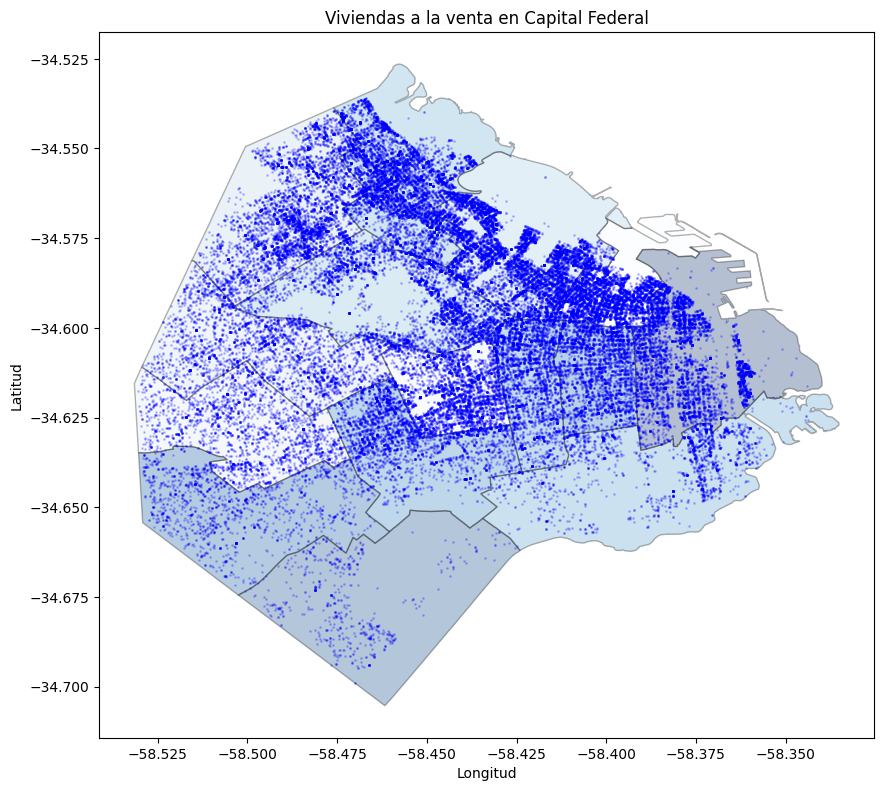

In [151]:
# Graficamos las viviendas en un mapa para visualizar su distribucion espacial
fig, ax = plt.subplots(figsize=(10,10))
df_comunas.plot(ax=ax,alpha=0.3, facecolor='Grey',edgecolor='k', linewidth=1, cmap='Blues').set(title='Viviendas a la venta en Capital Federal')
join.plot(ax=ax, alpha=0.2, color='blue', markersize=1).set(xlabel='Longitud', ylabel="Latitud")


**d) Reducción de la dimensionalidad:** en este punto se pide crear un nuevo dataset que
resulte de aplicar una reducción de dimensionalidad sobre el dataset que se obtuvo al
finalizar el preprocesamiento.

In [153]:
# Codigo

In [154]:
# Codigo

**Nota:** Los ítems a, b, c y d son los mínimos requeridos para esta etapa, cada grupo puede crear
nuevas variables que resulten derivadas de los atributos existentes o que resulten de incorporar
nuevas fuentes de datos.

### **2. Agrupamiento**
En este punto se busca analizar si es posible agrupar los datos en función de algún criterio. Para
esta tarea utilizar el algoritmo K-Means y se deberán realizar los siguientes puntos:
* Analizar la tendencia al *clustering* del dataset.
* Estimar la cantidad apropiada de grupos que se deben formar.
* Evaluar la calidad de los grupos formados realizando un análisis de *Silhouette*.
* Realizar un análisis de cada grupo intentando entender en función de qué
características fueron formados.
* Graficar sobre un mapa de CABA los avisos coloreados según el grupo al que
pertenecen.
* Repetir el análisis anterior, utilizando sólo 3 grupos.

In [192]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans

In [189]:
from pyclustertend import hopkins
# columns=['barrio','tipo','ambientes','dormitorios', 'superficie_total','superficie_cubierta','precio'] # Falta hacer encodings
columns=['ambientes','dormitorios', 'superficie_total','superficie_cubierta','precio','comuna']
hopkins(join.filter(columns), join.shape[0])

0.00010612738118679789

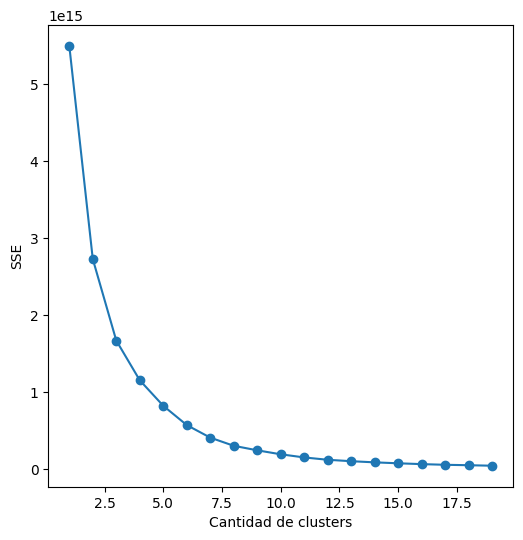

In [194]:
# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(join.filter(columns))
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

In [158]:
# Codigo

### **3. Clasificación**

**a) Construcción del target**

Para esta tarea se debe crear una nueva variable ***tipo_precio*** que tendrá tres categorías:
**alto**, **medio**, **bajo**. Esta nueva variable será nuestra clase en el problema de clasificación.
Para determinar cuándo el tipo_precio de una propiedad es alto, medio o bajo se deberá
analizar el precio por metro cuadrado (pxm2). Se propone evaluar las siguientes
alternativas para establecer los límites de cada categoría:

1. Dividir la variable *pxm2* en 3 intervalos con igual cantidad de observaciones.
2. Dividir la variable pxm2 en 3 intervalos, el primero con el 25% de las observaciones,
el siguiente con el 50% y el último con el 25% de las observaciones restantes.
3. Trabajar la variable pxm2 relativa a cada tipo de propiedad y luego dividirla como en
el punto anterior.

Se pide:
* Mostrar la distribución del precio por metro cuadrado
* Mostrar la distribución del precio por metro cuadrado por tipo de propiedad
* Para cada una de las tres alternativas mostrar gráficamente la distribución de la
nueva variable creada *tipo_precio*.
* Seleccionar una de las alternativas, justificando la misma.
* Comparar, si aplica, la alternativa seleccionada con la división en 3 grupos obtenida
utilizando agrupamiento por K Means.
* Mostrar en un mapa de CABA los avisos coloreados por *tipo_precio*

In [159]:
# Codigo

In [160]:
# Codigo

In [161]:
# Codigo

In [162]:
# Codigo

**b) Entrenamiento y Predicción**

Predecir el valor del atributo **tipo_precio**, excluyendo del entrenamiento la variable price,
**pxm2** y cualquier otra que pueda contener información del precio de venta. Para todos los
modelos se pide:
* Realizar las tareas de ingeniería de características necesarias para trabajar con
cada algoritmo (*encoding*, normalización, etc)
* Todos los modelos deben ser entrenados también con el *dataset* generado en el
punto **1 d)**


**Modelo 1 : Árbol de decisión**

a. Construir un árbol de decisión y optimizar sus hiperparámetros mediante *k-fold
Cross Validation* para obtener la mejor performance. ¿Cuántos *folds* utilizaron?
¿Qué métrica consideran adecuada para buscar los parámetros?

b. Graficar el árbol de decisión con mejor performance encontrado en el punto
anterior. Si es muy extenso mostrar una porción representativa.

c. Analizar el árbol de decisión seleccionado describiendo los atributos elegidos, y
decisiones evaluadas (explicar las primeras reglas obtenidas).

d. Evaluar la performance del árbol en el conjunto de evaluación, explicar todas las
métricas y mostrar la matriz de confusión. Comparar con la performance de
entrenamiento.


In [163]:
# Codigo

In [164]:
# Codigo

In [165]:
# Codigo

In [166]:
# Codigo

**Modelo 2: Random Forest**

a. Construir un clasificador RF y optimizar sus hiperparámetros mediante *k-fold
Cross Validation* para obtener la mejor performance. ¿Cuántos *folds* utilizaron?
¿Qué métrica consideran adecuada para buscar los parámetros?

b. Analizar la importancia de los atributos

c. Mostrar la conformación final de uno de los árboles generados. Si es muy
extenso mostrar una porción representativa y explicar las primeras reglas.

d. Evaluar la performance del modelo en el conjunto de evaluación, explicar todas
las métricas y mostrar la matriz de confusión. Comparar con la performance de
entrenamiento.


In [167]:
# Codigo

In [168]:
# Codigo

In [169]:
# Codigo

In [170]:
# Codigo

**Modelo 3: a elección**

a. En este punto se debe entrenar (mediante cross-validation) un modelo elegido
por el grupo. Se debe evaluar su performance en entrenamiento y sobre el
conjunto de evaluación, explicar todas las métricas y mostrar la matriz de
confusión.

In [171]:
# Codigo

In [172]:
# Codigo

In [173]:
# Codigo

In [174]:
# Codigo

¿Qué modelo elegirían para clasificar el tipo de precio de las propiedades?

R:

### **4. Regresión**

En esta etapa se busca predecir el precio de la propiedad utilizando dos modelos diferentes.
Para todos los modelos se pide:

* Realizar las tareas de ingeniería de características necesarias para trabajar con
cada algoritmo (encoding, normalización, etc)
* Todos los modelos deben ser entrenados también con el dataset generado en el
punto **1 d)**

**Modelo 1: KNN**

a. Construir un modelo [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) para regresión y optimizar sus hiperparámetros
mediante *k-fold Cross Validation* para obtener la mejor performance .¿Cuántos
*folds* utilizaron? ¿Qué métrica consideran adecuada para buscar los parámetros?

b. Evaluar la performance del modelo en el conjunto de evaluación, explicar todas
las métricas. Comparar con la performance de entrenamiento.

In [175]:
# Codigo

In [176]:
# Codigo

In [177]:
# Codigo

**Modelo 2: XGBoost**

a. Construir un modelo **XGBoost** y optimizar sus hiperparámetros mediante *k-fold
Cross Validation* para obtener la mejor performance. ¿Cuántos *folds* utilizaron?
¿Qué métrica consideran adecuada para buscar los parámetros?

b. Evaluar la performance del modelo en el conjunto de evaluación, explicar todas
las métricas. Comparar con la performance de entrenamiento.

In [178]:
# Codigo

In [179]:
# Codigo

In [180]:
# Codigo

**Modelo 3: a elección**

a. En este punto se debe entrenar (mediante *cross-validation*) un modelo elegido
por el grupo. Se debe evaluar su performance en entrenamiento y sobre el
conjunto de evaluación explicando todas las métricas.

In [181]:
# Codigo

In [182]:
# Codigo

In [183]:
# Codigo

¿Qué modelo elegirían para predecir el precio de venta de las propiedades?

R:

### **5. Conclusiones**

Realizar las conclusiones correspondientes al trabajo realizado en su totalidad, destacando
principalmente los aspectos que consideren más relevantes. Comentar brevemente qué otras
opciones hubiesen explorado y quedaron fuera del alcance de este trabajo

R: